In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import time
from sklearn.model_selection import TimeSeriesSplit, KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer, Flatten, Conv1D,Conv2D, ConvLSTM3D, Input,MaxPooling1D, concatenate,MaxPooling2D
from tensorflow.keras.regularizers import l1, l2
import keras_tuner
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV

Using TensorFlow backend


## Functions

In [54]:
def read_data_location(location: str):
    """
    Description
    -----------
    Read data from Parquet files located in a specified directory.

    This function reads the training target, observed training data, estimated training data,
    and estimated test data from Parquet files located in the specified directory.
    
    Parameters
    ----------
    - `location` (str): The directory path where the Parquet files are located.

    Returns
    -------
    - A tuple containing the following DataFrames:
      - `train_target` (pandas.DataFrame): Training target data.
      - `X_train_observed` (pandas.DataFrame): Observed training data.
      - `X_train_estimated` (pandas.DataFrame): Estimated training data.
      - `X_test_estimated` (pandas.DataFrame): Estimated test data.

    Example
    -------
    ```python
    data_location = '/path/to/data_directory'
    train_target, X_train_observed, X_train_estimated, X_test_estimated = read_data_location(data_location)
    ```
    """
    train_target = pd.read_parquet('../'+location+'/train_targets.parquet')
    X_train_observed = pd.read_parquet('../'+location+'/X_train_observed.parquet')
    X_train_estimated = pd.read_parquet('../'+location+'/X_train_estimated.parquet')
    X_test_estimated = pd.read_parquet('../'+location+'/X_test_estimated.parquet')
    return(train_target, X_train_observed, X_train_estimated, X_test_estimated)



def find_low_correlation_columns(dataframe, threshold, verbose = True):
    """
    Description
    -----------
    Find and remove columns in a DataFrame with low absolute correlation coefficients.

    This function calculates the pairwise correlation coefficients between columns in a DataFrame and
    removes columns that have absolute correlation coefficients equal to or above the specified threshold.
    It provides the option to print the removed columns for reference.

    Parameters
    ----------
    - `dataframe` (pandas.DataFrame): The DataFrame for which low correlation columns should be found.
    - `threshold` (float): The threshold for absolute correlation coefficients. Columns with absolute
                      correlation coefficients greater than or equal to this threshold will be removed.
    - `verbose` (bool, optional): If True, print information about removed columns. Default is True.

    Returns
    -------
    - List of column names that remain in the DataFrame after removing low correlation columns.

    Example
    -------
    ```python
    import pandas as pd

    data = {'feature1': [1, 2, 3, 4, 5],
            'feature2': [2, 3, 4, 5, 6],
            'feature3': [5, 6, 7, 8, 9]}

    df = pd.DataFrame(data)
    threshold = 0.7

    selected_columns = find_low_correlation_columns(df, threshold)
    ```
    """
    
    correlation_matrix = dataframe[:].corr()

    feature_list = list(correlation_matrix.columns)
    removed_list = []
    for reference_index in range(len(feature_list)):
        reference_feature = feature_list[reference_index]

        # Check if this feature has not already been removed
        if reference_feature not in removed_list:
            for compared_index in range(reference_index+1,len(feature_list)):
                compared_feature = feature_list[compared_index]

                # Check if this feature has not already been removed
                if compared_feature not in removed_list:

                    # Get correlation coefficient
                    coefficient = correlation_matrix.loc[reference_feature,compared_feature]

                    # Remove column if it's a NaN
                    if pd.isna(coefficient):
                        removed_list.append(compared_feature)
                        if verbose : print(f"Removed {compared_feature} because it is NaN")
                        
                    # Remove if it is above threshold
                    if np.abs(coefficient)>=threshold:
                        removed_list.append(compared_feature)
                        if verbose : print(f"Removed \t{compared_feature}\tbecause it is correlated to\t{reference_feature}")
    
    
    output_list = feature_list.copy()
    for element in removed_list:
        output_list.remove(element)
        
    return list(output_list)





def fill_nan(Dataframe: pd.DataFrame, feature: str, verbose: bool = True):
    """
    Description
    -----------
    Fill missing (`NaN`) values in a specified feature of a DataFrame using forward-fill or backward-fill.

    This function checks for missing values in the specified feature and fills them using forward-fill (`ffill`)
    or backward-fill (`bfill`) if necessary. It also provides information about the filled method and missing data.

    Parameters
    ----------
    - `Dataframe` (pandas.DataFrame): The DataFrame containing the feature with missing values.
    - `feature` (str): The name of the feature in the DataFrame.
    - `verbose` (bool): whether to display information about the column being filled and the method used

    Returns
    -------
    - None, but it updates the input DataFrame in place by filling missing values.

    Example
    -------
    ```python
    import pandas as pd

    data = {'date': pd.date_range(start='2023-01-01', periods=100, freq='D'),
            'value': [1, 2, np.nan, 4, np.nan, 6, 7, 8, np.nan, 10]}

    df = pd.DataFrame(data)
    feature = 'value'

    fill_nan(df, feature)
    ```
    """
    it_na = np.where(Dataframe[feature].isna())[0]
    
    #If missing value
    if len(it_na != 0):
        if verbose:
            print("Missing data in",feature," size ",it_na.size," out of", Dataframe.shape[0])
        new_column = Dataframe[feature].ffill()
        method = 'ffill'
        
        if((np.any(new_column.isna()) == True)): 
            method = 'bfill'
            new_column = Dataframe[feature].bfill()
    
        if (np.any(new_column.isna()) == False):
            if verbose:
                print("Filled with",method,"method")
            Dataframe[feature] = new_column
        else:
            if verbose:
                print("WARNING : still NaN values in "+feature)

def load_clean_datasets(location: str, threshold: float,verbose=True):
    """
    Description
    -----------
    Load and preprocess datasets, handling missing values and highly correlated features.

    This function loads four datasets from the specified location and processes them. It replaces colons in column names,
    identifies low-correlation features, and fills missing values using the `fill_nan` function.

    Parameters
    ----------
    - `location` (str): The path or URL to the data files.
    - `threshold` (float): The threshold for feature correlation identification.
    - `verbose` (bool): whether to display information about the dataset being processed

    Returns
    -------
    - Tuple of DataFrames: A tuple containing four DataFrames for train_target, X_train_observed, X_train_estimated, and X_test_estimated.
    - List of Lists of str: A list of lists containing the names of low-correlation features for each DataFrame.

    Example
    -------
    ```python
    train_target, X_train_observed, X_train_estimated, X_test_estimated, FEATURES = load_clean_datasets("data/location", 0.7)
    ```
    """
    train_target, X_train_observed, X_train_estimated, X_test_estimated = read_data_location(location = location)


    # Process NaNs and highly correlated features
    dataframes = [train_target,X_train_observed,X_train_estimated,X_test_estimated]
    dataframe_names = ["train_target","X_train_observed","X_train_estimated","X_test_estimated"]
    index = 0
    FEATURES = [] # Contains the list of useful features for each dataframe


    for dataframe in dataframes:
        if verbose:
            print("** WORKING ON "+dataframe_names[index]+"**")
        # Replace colons with underscores in column names of 'dataframe'
        dataframe.columns = dataframe.columns.str.replace(':', '_')
        # Find low find_low_correlation_columns
        features = find_low_correlation_columns(dataframe,threshold,verbose=False)
        FEATURES.append(features)
        # Fill NaN
        for feature in dataframe.columns:
            fill_nan(dataframe,feature,verbose=False)
        index+=1
    return (train_target, X_train_observed, X_train_estimated, X_test_estimated,FEATURES)

def select_and_resample(Xdf: pd.DataFrame,Ydf: pd.DataFrame):
    """
    Description
    -----------
    Select and resample time series data.

    This function selects data from two time series dataframes, `Xdf` and `Ydf`, where there is a match in time values.
    It then resamples `Ydf` to a 15-minute interval using linear interpolation and returns the resulting time-aligned data.
    The output data contains only streaks of minutes `[15, 30, 45, 00]`.

    Parameters
    ----------
    - `Xdf` (pandas.DataFrame): The first time series dataframe containing `'date_forecast'` column.
    - `Ydf` (pandas.DataFrame): The second time series dataframe containing `'time'` column.

    Returns
    -------
    - Tuple of two pandas DataFrames:
      - The selected and filtered X values, with a 15-minute interval.
      - The resampled Y values, matching the selected X values.

    Example
    -------
    ```python
    Xdf = pd.DataFrame({'date_forecast': pd.date_range(start='2023-01-01', periods=100, freq='15T')})
    Ydf = pd.DataFrame({'time': pd.date_range start='2023-01-01', periods=200, freq='30T')})
    selected_X, selected_Y = select_and_resample(Xdf, Ydf)
    ```
    """
    
    ##### Select Y values where there are X values :
    Y_in_X_times = Ydf['time'].isin(Xdf['date_forecast'])
    Selected_Y = Ydf[Y_in_X_times].reset_index(drop=True)
    
    ##### Select X values where there are Y values
    # ceil the date forecast to the hour in Xdf
    Xdf['hourly_forecast'] = Xdf['date_forecast'].dt.ceil('H')
    X_in_Y_times = Xdf['hourly_forecast'].isin(Selected_Y['time'])
    Selected_X = Xdf[X_in_Y_times].reset_index(drop=True).drop(columns=['hourly_forecast'])

    #### Filter X values to get 4 consecutive 15 minutes
    valid_minutes = [15, 30, 45, 0]
    # Calculate the difference in minutes between consecutive rows
    Selected_X = Selected_X.sort_values('date_forecast')
    Selected_X['minute_diff'] = Selected_X['date_forecast'].diff().dt.total_seconds() / 60
    # Create a mask to identify valid minutes
    valid_mask = Selected_X['minute_diff'].isin(valid_minutes)
    # Create a mask to identify the start of consecutive valid minute streaks
    streak_start_mask = valid_mask & (~valid_mask.shift(1, fill_value=False))
    # Create a mask to identify the end of consecutive valid minute streaks
    streak_end_mask = valid_mask & (~valid_mask.shift(-1, fill_value=False))
    # Merge the start and end masks to get the full streak mask
    consecutive_streak_mask = streak_start_mask | streak_end_mask
    # Extend the streaks to include isolated values
    consecutive_streak_mask = consecutive_streak_mask | consecutive_streak_mask.shift(1, fill_value=False) | consecutive_streak_mask.shift(-1, fill_value=False)
    # Repeatedly extend the streaks until no more can be extended
    while True:
        extended_streaks = consecutive_streak_mask | consecutive_streak_mask.shift(1, fill_value=False) | consecutive_streak_mask.shift(-1, fill_value=False)
        if extended_streaks.equals(consecutive_streak_mask):
            break
        consecutive_streak_mask = extended_streaks
    # Identify the cases where the streaks start with non-15 minutes
    non_15_start = valid_mask & (streak_start_mask | streak_end_mask)
    consecutive_streak_mask = consecutive_streak_mask | non_15_start

    Selected_X_filtered = Selected_X[consecutive_streak_mask].drop(columns='minute_diff')

    #### Resample Ydf with 15 minute interval 
    Selected_Y.set_index('time', inplace=True)
    Selected_Y_resampled = Selected_Y.resample('15T').interpolate(method='linear') #  use 'nearest' for flatter interpolation
    Selected_Y_resampled = Selected_Y_resampled.reset_index()

    # Select Y resampled values where there are X values :
    Y_in_X_times_resampled = Selected_Y_resampled['time'].isin(Selected_X_filtered['date_forecast'])
    Selected_Y = Selected_Y_resampled[Y_in_X_times_resampled].reset_index(drop=True)
    # Again the other way round to remove data that passed through the filter
    Selected_X = Selected_X_filtered[Selected_X_filtered['date_forecast'].isin(Selected_Y['time'])].reset_index(drop=True)


    return(Selected_X[1:], Selected_Y[1:])  # remove first row which always starts with a 00

def remove_consecutive_identical_values(df: pd.DataFrame, feature: str):
    """
    Description
    -----------
    Remove rows with consecutive identical values in a specified feature of a DataFrame.

    Paramters
    ---------
    - `df` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature in the DataFrame.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with consecutive identical values removed.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time': pd.date_range(start='2023-01-01', periods=100, freq='15T'),
            'value': [1, 2, 2, 3, 3, 3, 4, 4, 4, 4]}

    df = pd.DataFrame(data)
    feature = 'value'

    filtered_df = remove_consecutive_identical_values(df, feature)
    ```
    """
    # Identify rows with consecutive identical values in the specified feature
    mask = df[feature] != df[feature].shift(+1)

    # Filter and remove rows with consecutive identical values
    filtered_df = df[mask]

    return filtered_df

def remove_consecutive_identical_values_keep_zeros(df: pd.DataFrame, feature: str):
    """
    Description
    -----------
    Remove rows with consecutive identical values (excluding 0) in a specified feature of a DataFrame.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature in the DataFrame.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with consecutive identical values (excluding 0) removed.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time': pd.date_range(start='2023-01-01', periods=100, freq='15T'),
            'value': [1, 2, 2, 3, 3, 3, 4, 4, 0, 0, 0, 4, 4]}

    df = pd.DataFrame(data)
    feature = 'value'

    filtered_df = remove_consecutive_identical_values(df, feature)
    ```
    """
    # Identify rows with consecutive identical values in the specified feature
    mask = (df[feature] != df[feature].shift(+1)) | (df[feature] == 0)

    # Filter and remove rows with consecutive identical values, excluding 0
    filtered_df = df[mask]

    return filtered_df


def select_o_clock(dataframe: pd.DataFrame, feature: str) -> pd.DataFrame:
    """
    Description
    -----------
    Select rows from a DataFrame where the time in the specified feature is a round hour (minute and second are 0) and sort them by the 'feature' column.

    Parameters
    ----------
    - `dataframe` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature column containing time values.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with rows where the time is a round hour, sorted by the 'feature' column.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time_column': pd.date_range(start='2023-01-01', periods=100, freq='H')}

    df = pd.DataFrame(data)
    feature = 'time_column'

    filtered_df = select_o_clock(df, feature)
    ```
    """
     # Check if the feature column exists in the DataFrame
    if feature not in dataframe.columns:
        raise ValueError(f"'{feature}' column not found in the DataFrame")

    # Check if the feature column is of datetime type
    if not pd.api.types.is_datetime64_any_dtype(dataframe[feature]):
        raise ValueError(f"'{feature}' column should be of datetime type")

    # Filter the DataFrame to select rows with round-hour times
    filtered_df = dataframe[dataframe[feature].dt.minute == 0 & (dataframe[feature].dt.second == 0)]
    
    # Sort the filtered DataFrame by the 'feature' column
    filtered_df = filtered_df.sort_values(by=feature)

    return filtered_df

def lagged_features2(df):
    # Define the time intervals for lag
    time_intervals = [15, 30, 45]

    # Create a new DataFrame to store the lagged features
    new_df = df.copy()

    # Loop through the time intervals and create lagged features
    for interval in time_intervals:
        # Create a suffix for the column names
        suffix = '__r' + str(interval)

        # Loop through the columns in the original DataFrame
        for column in df.columns:
            # Exclude the 'date_forecast' and 'date_calc' columns
            if column not in ['date_forecast', 'date_calc']:
                # Shift the values by the specified time interval
                new_df[column + suffix] = new_df[column].copy().shift(periods=interval//15)

    # Fill missing values with the last known value for each specific column
    for column in new_df.columns:
        fill_nan(new_df,column,verbose=False)

    return new_df

def lagged_features(df, time_intervals = [15,30,45],verbose=False):
    """
    Description
    -----------
    Generate lagged features in a DataFrame based on specified time intervals.

    This function creates lagged features for selected columns in the DataFrame by shifting the data back in time based on
    the provided time intervals. It then fills in missing values using the `fill_nan` function.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to which lagged features will be added.
    - `time_intervals` (List[int]): List of time intervals (in minutes) for creating lagged features.
    - `verbose` (bool): Whether to display information about the lagged features being created.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with lagged features added and missing values filled.

    Example
    -------
    ```python
    data = {'date_forecast': pd.date_range(start='2023-01-01', periods=100, freq='H'),
            'value1': [1, 2, 3, 4, 5],
            'value2': [10, 20, 30, 40, 50]}

    df = pd.DataFrame(data)
    time_intervals = [15, 30, 45]

    lagged_df = lagged_features(df, time_intervals)
    ```
    """

    if time_intervals==0:
        return df
    
    new_df = df.copy()      
    new_columns = []

    for interval in time_intervals:
        # Create a suffix for the column names
        suffix = '__r' + str(interval)

        lagged_df = new_df.shift(interval//15).copy()

        for column in df.columns:
            if column not in ['date_forecast', 'date_calc']:
                lag_name=column + suffix
                if verbose: print(lag_name)
                # Add lagged column
                new_column = pd.DataFrame()
                new_column[lag_name] = new_df[column].copy()
                # Get the value at the shifted time
                mask = (new_df['date_forecast']-pd.to_timedelta(interval, unit='minutes') == lagged_df['date_forecast'])
                new_column.loc[mask,lag_name] = lagged_df.loc[mask,column]
                # Fix values where there is no data available
                new_column.loc[np.logical_not(mask),lag_name]=np.nan
                new_columns.append(new_column)

    new_df = pd.concat([new_df]+new_columns,axis=1)

    # Fill missing values with the last known value for each specific column
    for column in new_df.columns:
        fill_nan(new_df,column,verbose=False)
    
    return new_df


def lagged_features_selected(df,feature_list: list, time_intervals = [15,30,45],verbose=False):

    if feature_list not in df.columns:
        ValueError("Features are not in the DataFrame columns")

    if time_intervals==0:
        return df
    
    new_df = df.copy()      
    new_columns = []

    for interval in time_intervals:
        # Create a suffix for the column names
        suffix = '__r' + str(interval)

        lagged_df = new_df.shift(interval//15).copy()

        for feature in feature_list:
            if column not in ['date_forecast', 'date_calc', 'sin_day', 'sin_year',' cos_year', 'forecast_interval']:
                lag_name=column + suffix
                if verbose: print(lag_name)
                # Add lagged column
                new_column = pd.DataFrame()
                new_column[lag_name] = new_df[column].copy()
                # Get the value at the shifted time
                mask = (new_df['date_forecast']-pd.to_timedelta(interval, unit='minutes') == lagged_df['date_forecast'])
                new_column.loc[mask,lag_name] = lagged_df.loc[mask,column]
                # Fix values where there is no data available
                new_column.loc[np.logical_not(mask),lag_name]=np.nan
                new_columns.append(new_column)

    new_df = pd.concat([new_df]+new_columns,axis=1)

    # Fill missing values with the last known value for each specific column
    for column in new_df.columns:
        fill_nan(new_df,column,verbose=False)
    
    return new_df


def normalize_dataframe_minmax(df: pd.DataFrame,verbose = False):
    """
    Description
    -----------
    Normalize a DataFrame using min-max scaling, excluding datetime columns.

    This function performs min-max scaling to normalize each column in the DataFrame between 0 and 1,
    excluding datetime columns. It replaces the original values with the scaled values.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to be normalized.
    - `verbose` (bool): Whether to display information about the columns being normalized.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with columns normalized between -1 and 1.

    Example
    -------
    ```python
    data = {'feature1': [1, 2, 3, 4, 5],
            'feature2': [10, 20, 30, 40, 50],
            'date': pd.date_range(start='2023-01-01', periods=5, freq='D')}

    df = pd.DataFrame(data)

    normalized_df = normalize_dataframe(df)
    ```
    """
    normalized_df = df.copy()
    # Define the range [0, 1]
    min_range = 0
    max_range = 1
    
    # Iterate over each column and apply min-max scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            min_val = normalized_df[column].min()
            max_val = normalized_df[column].max()
            if verbose:
                print(f"min:{min_val:.2f}\tmax:{max_val:.2f}")
                print(f"different:{min_val!=max_val}")
            # Normalize the non-datetime column between -1 and 1
            if min_val!=max_val:
                normalized_df[column] = min_range + (max_range - min_range) * (normalized_df[column] - min_val) / (max_val - min_val)
            else :
                normalized_df[column] = min_range + (max_range - min_range) * normalized_df[column]/max(max_val,1)

    return normalized_df

def normalize_dataframe_minmax_TEST(train_df: pd.DataFrame,test_df: pd.DataFrame,verbose = False):
    """
    Description
    -----------
    Normalize a test DataFrame using min-max scaling, based on statistics from a training DataFrame.

    This function performs min-max scaling to normalize each column in the test DataFrame between 0 and 1,
    using the minimum and maximum values from the corresponding columns in the training DataFrame.
    
    Parameters
    ----------
    - `train_df` (pandas.DataFrame): The training DataFrame used to calculate min-max scaling statistics.
    - `test_df` (pandas.DataFrame): The test DataFrame to be normalized.
    - `verbose` (bool): Whether to display information about the columns being normalized.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with columns in the test DataFrame normalized based on the statistics from the training DataFrame.

    Example
    -------
    ```python
    train_data = {'feature1': [1, 2, 3, 4, 5],
                 'feature2': [10, 20, 30, 40, 50]}
    
    test_data = {'feature1': [6, 7, 8, 9, 10],
                'feature2': [60, 70, 80, 90, 100]}
    
    train_df = pd.DataFrame(train_data)
    test_df = pd.DataFrame(test_data)
    
    normalized_test_df = normalize_dataframe_TEST(train_df, test_df)
    ```
    """

    normalized_df = test_df.copy()
    # Define the range [0, 1]
    min_range = 0
    max_range = 1
    
    # Iterate over each column and apply min-max scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            min_val = train_df[column].min()
            max_val = train_df[column].max()
            if verbose:
                print(f"min:{min_val:.2f}\tmax:{max_val:.2f}")
                print(f"different:{min_val!=max_val}")
            # Normalize the non-datetime column between -1 and 1
            if min_val!=max_val:
                normalized_df[column] = min_range + (max_range - min_range) * (normalized_df[column] - min_val) / (max_val - min_val)
            else :
                normalized_df[column] = min_range + (max_range - min_range) * normalized_df[column]/max(max_val,1)

    return normalized_df

def normalize_dataframe_mean_std(df: pd.DataFrame,verbose = False):
    """
    Description
    -----------
    Normalize a DataFrame using mean and standard deviation scaling.

    This function performs mean and standard deviation scaling to normalize each column in the DataFrame using the
    mean and standard deviation values calculated from the same DataFrame.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to be normalized.
    - `verbose` (bool): Whether to display information about the columns being normalized.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with columns normalized based on mean and standard deviation values.

    Example
    -------
    ```python
    import pandas as pd

    data = {'feature1': [1, 2, 3, 4, 5],
            'feature2': [10, 20, 30, 40, 50]}

    df = pd.DataFrame(data)

    normalized_df = normalize_dataframe_mean_std(df)
    ```
    """

    normalized_df = df.copy()
    # Iterate over each column and apply mean/std scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            mean = normalized_df[column].mean()
            std = normalized_df[column].std()
            if verbose:
                print(f"mean:{mean:1f} \tstd:{std:.1f}")
            if std!=0:
                normalized_df[column] = (normalized_df[column] - mean) / std
            else :
                normalized_df[column] = (normalized_df[column] - mean) / 1

    return normalized_df



def normalize_dataframe_mean_std_TEST(train_df: pd.DataFrame,test_df: pd.DataFrame,verbose = False):
    """
    Description
    -----------
    Normalize a test DataFrame using mean and standard deviation scaling, based on statistics from a training DataFrame.

    This function performs mean and standard deviation scaling to normalize each column in the test DataFrame using the
    mean and standard deviation values from the corresponding columns in the training DataFrame.

    Parameters
    ----------
    - `train_df` (pandas.DataFrame): The training DataFrame used to calculate mean and standard deviation statistics.
    - `test_df` (pandas.DataFrame): The test DataFrame to be normalized.
    - `verbose` (bool): Whether to display information about the columns being normalized.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with columns in the test DataFrame normalized based on mean and standard deviation
    statistics from the training DataFrame.

    Example
    -------
    ```python
    import pandas as pd

    train_data = {'feature1': [1, 2, 3, 4, 5],
                 'feature2': [10, 20, 30, 40, 50]}
    
    test_data = {'feature1': [6, 7, 8, 9, 10],
                'feature2': [60, 70, 80, 90, 100]}
    
    train_df = pd.DataFrame(train_data)
    test_df = pd.DataFrame(test_data)
    
    normalized_test_df = normalize_dataframe_mean_std_TEST(train_df, test_df)
    ```
    """
    normalized_df = test_df.copy()

    # Iterate over each column and apply mean/std scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            mean = train_df[column].mean()
            std = train_df[column].std()
            if verbose:
                print(f"mean:{mean:1f} \tstd:{std:.1f}")
            if std!=0:
                normalized_df[column] = (normalized_df[column] - mean) / std
            else :
                normalized_df[column] = (normalized_df[column] - mean) / 1

    return normalized_df


def convert_datetime(df: pd.DataFrame, time_feature: str):
    new_df = df.copy()

    # Convert the 'time_feature' column to datetime if it's not already
    new_df[time_feature] = pd.to_datetime(new_df[time_feature])

    # Calculate the number of seconds since midnight and subtract it from 86400 to make it -1 at midnight
    new_df['seconds_since_midnight'] = (new_df[time_feature] - new_df[time_feature].dt.normalize()).dt.total_seconds()

    # Calculate the sine of the day with -1 at midnight
    new_df['sin_day'] = np.sin(2 * np.pi * new_df['seconds_since_midnight']/86400- np.pi/2)

    # Calculate the sine of the year with -1 on January 1st
    new_df['sin_year'] = np.sin(2 * np.pi * (new_df[time_feature].dt.dayofyear - 1)/365 - np.pi/2)

    # Calculate the cosine of the year with -1 on January 1st
    new_df['cos_year'] = np.cos(2 * np.pi * (new_df[time_feature].dt.dayofyear - 1)/365 - np.pi/2)

    # Calculate the difference in seconds between 'time_feature' and 'date_calc'
    #new_df['forecast_interval'] = (new_df[time_feature] - new_df['date_calc']).dt.total_seconds().fillna(0)

    # Drop the temporary 'seconds_since_midnight' column if you don't need it
    new_df.drop('seconds_since_midnight', axis=1, inplace=True)

    return new_df

def full_data_loader(location,n_lagged_features=3,threshold=0.9,normalization = 'minmax',date_encoding=True,verbose=True):
    """
    Description
    -----------
    Load, preprocess, and prepare data for training and prediction including feature engineering, normalization, and resampling.

    This function reads datasets, selects usable data, adds date encoding features, lagged features, and normalizes the data.

    Parameters
    ----------
    - `location` (str): The path or URL to the data files.
    - `n_lagged_features` (int): The number of lagged features to add.
    - `threshold` (float): The threshold for feature correlation identification.
    - `normalization` (str): The type of data normalization ('minmax' or 'mean'), or 'none' for no normalization.
    - `date_encoding` (bool): Whether to add date encoding features.
    - `verbose` (bool): Whether to display progress and information.

    Returns
    -------
    - Tuple of DataFrames, Series, and List: A tuple containing X_Train, Y_Train, X_Test, and a list of selected features.

    Example
    -------
    ```python
    location = "data/location"
    n_lagged_features = 3
    threshold = 0.9
    normalization = 'minmax'
    date_encoding = True
    verbose = True

    X_Train, Y_Train, X_Test, selected_features = full_data_loader(
        location, n_lagged_features, threshold, normalization, date_encoding, verbose
    )
    ```
    """
    # Read datasets
    if verbose: print("Reading datasets")
    train_target, X_train_observed, X_train_estimated, X_test_estimated, FEATURES = load_clean_datasets(location, threshold,verbose=False)
    
    selected_features = FEATURES[-1][1:] # all low correlation features from X_train_observed except date

    # Select usable data and resample training target
    if verbose: print("Selecting training data")
    Ydf = remove_consecutive_identical_values(train_target,'pv_measurement')
    Xdf = pd.concat([X_train_observed,X_train_estimated]).reset_index(drop=True)
    X_Train,Y_Train = select_and_resample(Xdf,Ydf)
    
    # Add features to encode the date information
    if date_encoding:
        if verbose: print("Encoding date information")
        X_Train = convert_datetime(X_Train,'date_forecast')
        X_Test = convert_datetime(X_test_estimated, 'date_forecast')
        # 
    else:
        X_Test = X_test_estimated
    
    if date_encoding:
        selected_features += ['sin_day','sin_year','cos_year','forecast_interval']

    # Add lagged features
    if n_lagged_features!=0:
        if verbose: print("Adding lag features")
        time_lags = [15*n for n in range(1,n_lagged_features+1)] # in minutes
        X_Train = lagged_features(X_Train,time_intervals=time_lags,verbose=False)
        X_Test = lagged_features(X_Test,time_intervals=time_lags,verbose=False)
        feature_list = selected_features
        suffix_list = ['']+[f"__r{lag}" for lag in time_lags]
        selected_features = [f+suffix for f in feature_list for suffix in suffix_list]


    # Normalize datasets
    if normalization in ['minmax', 'mean']:
        if verbose:print("Normalizing with "+normalization)
        if normalization == 'minmax':
            X_Train_normal = normalize_dataframe_minmax(X_Train)
            X_Test_normal = normalize_dataframe_minmax_TEST(X_Train,X_Test)
        if normalization == 'mean':
            X_Train_normal = normalize_dataframe_mean_std(X_Train)
            X_Test_normal = normalize_dataframe_mean_std_TEST(X_Train,X_Test)
        X_Train = X_Train_normal
        X_Test = X_Test_normal


    
    print("\nDone\n")
    return (X_Train,Y_Train['pv_measurement'],X_Test,selected_features)


def full_data_loader_separate(location,n_lagged_features=3,threshold=0.9,normalization = 'minmax',date_encoding=True,verbose=True):
    """
    Description
    -----------
    Load, preprocess, and prepare data for training and prediction including feature engineering, normalization, and resampling.

    This function reads datasets, selects usable data, adds date encoding features, lagged features, and normalizes the data.

    Parameters
    ----------
    - `location` (str): The path or URL to the data files.
    - `n_lagged_features` (int): The number of lagged features to add.
    - `threshold` (float): The threshold for feature correlation identification.
    - `normalization` (str): The type of data normalization ('minmax' or 'mean'), or 'none' for no normalization.
    - `date_encoding` (bool): Whether to add date encoding features.
    - `verbose` (bool): Whether to display progress and information.

    Returns
    -------
    - Tuple of DataFrames, Series, and List: A tuple containing X_Train_obs,X_Train_est, Y_Train_obs,Y_Train_est X_Test_normalized_obs,X_Test_normalized_est and a list of selected features.

    Example
    -------
    ```python
    location = "data/location"
    n_lagged_features = 3
    threshold = 0.9
    normalization = 'minmax'
    date_encoding = True
    verbose = True

    X_Train, Y_Train, X_Test, selected_features = full_data_loader(
        location, n_lagged_features, threshold, normalization, date_encoding, verbose
    )
    ```
    """
    # Read datasets
    if verbose: print("Reading datasets")
    train_target, X_train_observed, X_train_estimated, X_test_estimated, FEATURES = load_clean_datasets(location, threshold,verbose=False)
    
    X_train_estimated = X_train_estimated.drop(columns='date_calc')
    X_test_estimated = X_test_estimated.drop(columns='date_calc')
    
    selected_features = FEATURES[-1][1:] # all low correlation features from X_train_observed except date

    # Select usable data and resample training target
    if verbose: print("Selecting training data")
    Ydf = remove_consecutive_identical_values(train_target,'pv_measurement')
    X_Train_obs, Y_Train_obs = select_and_resample(X_train_observed, Ydf)
    X_Train_est, Y_Train_est = select_and_resample(X_train_estimated, Ydf)

 
    # Add features to encode the date information
    if date_encoding:
        if verbose: print("Encoding date information")
        X_Train_obs = convert_datetime(X_Train_obs,'date_forecast')
        X_Train_est = convert_datetime(X_Train_est,'date_forecast')
        X_Test = convert_datetime(X_test_estimated, 'date_forecast')
        # 
    else:
        X_Test = X_test_estimated
    
    if date_encoding:
        selected_features += ['sin_day','sin_year','cos_year']

    # Add lagged features
    if n_lagged_features!=0:
        if verbose: print("Adding lag features")
        time_lags = [15*n for n in range(1,n_lagged_features+1)] # in minutes
        X_Train_obs = lagged_features(X_Train_obs,time_intervals=time_lags,verbose=False)
        X_Train_est = lagged_features(X_Train_est,time_intervals=time_lags,verbose=False)
        X_Test = lagged_features(X_Test,time_intervals=time_lags,verbose=False)
        feature_list = selected_features
        suffix_list = ['']+[f"__r{lag}" for lag in time_lags]
        selected_features = [f+suffix for f in feature_list for suffix in suffix_list]
   
    
    # Normalize datasets
    if normalization in ['minmax', 'mean']:
        if verbose:print("Normalizing with "+normalization)
        if normalization == 'minmax':
            X_Train_obs_normal = normalize_dataframe_minmax(X_Train_obs)
            X_Train_est_normal = normalize_dataframe_minmax(X_Train_est)
            X_Test_normal_with_obs = normalize_dataframe_minmax_TEST(X_Train_obs,X_Test)
            X_Test_normal_with_est = normalize_dataframe_minmax_TEST(X_Train_est,X_Test)
        if normalization == 'mean':
            X_Train_obs_normal = normalize_dataframe_mean_std(X_Train_obs)
            X_Train_est_normal = normalize_dataframe_mean_std(X_Train_est)
            X_Test_normal_with_obs = normalize_dataframe_mean_std_TEST(X_Train_obs,X_Test)
            X_Test_normal_with_est = normalize_dataframe_mean_std_TEST(X_Train_est,X_Test)
        X_Train_obs = X_Train_obs_normal
        X_Train_est = X_Train_est_normal
        X_Test_obs = X_Test_normal_with_obs
        X_Test_est = X_Test_normal_with_est

    print("\nDone\n")
    return (X_Train_obs,X_Train_est,Y_Train_obs['pv_measurement'],Y_Train_est['pv_measurement'],X_Test_obs,X_Test_est,selected_features)


def create_NN_model(input_shape):
    """
    Description
    -----------
    Create a neural network model.

    Parameters
    ----------
    - input_shape (tuple): The shape of the input data

    Returns
    ---------
    - tf.keras.Model: A TensorFlow/Keras neural network model.
    """

    model_NN = Sequential()
    model_NN.add(Input(shape=(input_shape)))
    model_NN.add(Dense(input_shape, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))    # Input layer
    model_NN.add(Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))            # Hidden layer
    model_NN.add(Dense(512, activation='relu'))            # Hidden layer
    model_NN.add(Dropout(0.2))                             # 20% dropout layer
    model_NN.add(Dense(256, activation='relu'))            # Hidden layer
    model_NN.add(Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))            # Hidden layer
    model_NN.add(Dropout(0.2))                             # 20% dropout layer
    model_NN.add(Dense(64, activation='relu'))             # Hidden layer
    model_NN.add(Dropout(0.2))                             # 20% dropout layer
    model_NN.add(Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))             # Hidden layer
    model_NN.add(Dense(1, activation='linear')) # Output layer

    return model_NN

def reshape_data_for_LSTM(X_dataframe, n_lag):
    """
    Description
    -----------
    Reshape Dataframe for input into LSTM model.
    
    Parameters
    ----------
    - X_dataframe (Dataframe) : Dataframe to reshape. Lagged feature as to be next to each other in the column
    - n_lag (int) : Number of lag available in the Dataframe

    Returns:
    - X_to_return (numpy array) : Dataset reshaped.
    """

    n_feature = round(X_dataframe.shape[1]/(n_lag+1))
    X_to_return = np.zeros((X_dataframe.shape[0],n_lag+1,n_feature))
    print(X_to_return.shape)
    for i in range(0,n_feature):
        X_to_return[:,:,i] = X_dataframe.iloc[:,(n_lag+1)*i:(n_lag+1)*i+n_lag+1]
    return X_to_return

def remove_lagged_features(Dataframe):
    """
    Description
    -----------
    Remove lagged feature in Dataframe.
    
    Parameters
    ----------
    - Dataframe (Dataframe) : Dataframe where lagged feature has to be removed. Lagged features as to contain '_r' in their column's names

    Returns:
    - dataframe_new (Dataframe) : Dataframe without lagged features
    """

    columns = Dataframe.columns
    mask = filter(lambda a: '_r' in a, columns)
    columns_to_deleted = list(mask)
    dataframe_new = Dataframe.drop(columns = columns_to_deleted)
    return dataframe_new


# 

# Messy notebook

In [2]:
#Path management 
def list_directory_tree_with_os_walk(starting_directory):
    for root, directories, files in os.walk(starting_directory):
        print(f"Directory: {root}")
        for file in files:
            print(f"  File: {file}")

# Check the directory
starting_directory_noe = 'C:/Users/Noe/source/repos/Energy-forecasting-NTNU/data/'
starting_directory_hugo = 'C:/Users/hugob/OneDrive/Documents/ENSE3/3A/lectures/Machine Learning/Project/git/Energy-forecasting-NTNU/data'
os.chdir(starting_directory_hugo)
list_directory_tree_with_os_walk('.')

Directory: .
  File: .DS_Store
  File: my_first_submission_utf8.csv
  File: my_second_submission.csv
  File: Readme.md
  File: read_files.ipynb
  File: sample_submission.csv
  File: submission1.csv
  File: test.csv
Directory: .\.ipynb_checkpoints
  File: Data_exploration-checkpoint.ipynb
  File: Readme-checkpoint.md
  File: read_files-checkpoint.ipynb
Directory: .\A
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\B
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\C
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\catboost_info
  File: catboost_training.json
  File: learn_error.tsv
  File: test_error.tsv
  File: time_left.tsv
Directory: .\catboost_info\learn
  File: events.out.tfevents
Directory: .\catboost_i

In [3]:
#Load datasets #
#Targets
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

# Train estimated data
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

# Train observed data
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

#Test estimated data
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

#List of dataset
Train_datasets = [X_train_observed_a, X_train_observed_b, X_train_observed_c, 
            X_train_estimated_a, X_train_estimated_b,X_train_estimated_c
            ]
Train_datasets_names = [ "X_train_observed_a", "X_train_observed_b", "X_train_observed_c",
                        "X_train_estimated_a", "X_train_estimated_b", "X_train_estimated_c"
                        ]

Test_datasets = [X_test_estimated_a, X_test_estimated_b, X_test_estimated_c]

Target_datasets = [train_a, train_b, train_c]

### Quick data management for missing values

In [4]:
# Remove snow_density variable because too many Nan ==> Useless
for i, dataset in enumerate(Train_datasets):
    dataset = dataset.drop(columns = 'snow_density:kgm3')
    Train_datasets[i] = dataset

In [5]:
# Function to fill gaps in dataset
def fill_nan(Dataframe, feature):
    it_na = np.where(Dataframe[feature].isna())[0]
    
    #If missing value
    if len(it_na != 0):
        method = 'ffill' # ffill: Propagate last valid observation forward to next valid
        new_column = Dataframe[feature].fillna(method='ffill')
        
        if((np.any(new_column.isna()) == True)): 
            method = 'bfill' # bfill :Fill values by using the next valid observation to fill the gap.
            new_column = Dataframe[feature].fillna(method='bfill')
    
        if (np.any(new_column.isna()) == False):
            print("==> ", feature, " filled with ",method," method")
            Dataframe[feature] = new_column
        else:
            print("Still Nan values !!!")

In [6]:
# Fill for each train dataset for each variable where there is some Nan
for i, dataset in enumerate(Train_datasets):
    print("Dataset : ",  Train_datasets_names[i])
    nan_features = [var for var in dataset.columns if dataset[var].isnull().sum() > 0]
    for features in nan_features:
        fill_nan(dataset, features)
    print("\n")

Dataset :  X_train_observed_a
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_observed_b
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_observed_c
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_estimated_a
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_estimated_b
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method


Dataset :  X_train_estimated_c
==>  ceiling_height_agl:m  filled with  ffill  method
==>  cloud_base_agl:m  filled with  ffill  method




### Feature engineering

In [7]:
# Check for correlation
set_nbr = 0
corr_matrix = Train_datasets[set_nbr].corr()
print(Train_datasets_names[set_nbr])
corr_matrix.style.background_gradient(cmap='coolwarm')

X_train_observed_a


c:\Users\hugob\anaconda3\lib\site-packages\pandas\io\formats\style.py:3555: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\hugob\anaconda3\lib\site-packages\pandas\io\formats\style.py:3556: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
absolute_humidity_2m:gm3,1.000000,-0.804124,0.110840,0.352801,0.349927,0.024787,0.123430,0.974863,0.284847,0.291109,0.239287,0.243773,0.021256,nan,-0.119009,-0.069179,-0.148714,-0.085105,-0.098863,0.304652,-0.322754,0.147830,0.067724,-0.025242,0.165345,0.154403,-0.055802,0.261640,0.160016,0.143458,-0.203685,nan,-0.013563,0.034042,0.022875,0.432344,0.110364,0.900297,0.043038,-0.158686,-0.157917,0.050106,-0.258794,0.004869
air_density_2m:kgm3,-0.804124,1.000000,-0.159707,-0.473967,-0.463355,-0.105238,-0.060455,-0.838733,-0.402079,-0.415496,-0.393769,-0.409485,-0.067100,nan,0.063038,0.044146,0.075154,0.052815,0.058816,-0.386344,0.402335,0.280098,-0.084777,-0.012127,0.263756,0.275654,0.072122,-0.162900,0.141432,0.287484,0.316890,nan,0.013984,-0.065673,-0.067960,-0.504503,-0.063599,-0.915070,-0.103049,-0.011076,-0.017527,0.026196,0.142869,-0.000575
ceiling_height_agl:m,0.110840,-0.159707,1.000000,0.071831,0.066778,0.664970,0.037937,0.101108,0.055368,0.058749,0.236082,0.243613,-0.377015,nan,-0.018965,-0.010354,-0.026045,-0.014081,-0.016165,0.052470,-0.056461,0.097773,-0.012913,-0.063670,0.102267,0.099780,0.025814,-0.150385,-0.388320,0.097302,-0.061680,nan,-0.028779,-0.179834,0.040713,0.078340,-0.322444,0.255581,-0.187227,0.423864,-0.172588,-0.305707,-0.010682,-0.003096
clear_sky_energy_1h:J,0.352801,-0.473967,0.071831,1.000000,0.992332,0.053497,-0.080023,0.362016,0.911178,0.922412,0.719660,0.732282,0.002814,nan,-0.056605,-0.037862,-0.072751,-0.046583,-0.052732,0.650795,-0.690138,0.157747,-0.008042,-0.032567,0.160357,0.154124,-0.050700,0.054178,-0.339914,0.147883,-0.074640,nan,-0.020592,-0.039219,0.056788,0.847872,0.016904,0.438994,0.009891,0.092573,0.013025,0.069513,-0.343041,-0.005087
clear_sky_rad:W,0.349927,-0.463355,0.066778,0.992332,1.000000,0.050362,-0.079422,0.359138,0.917222,0.914733,0.727173,0.728482,0.003273,nan,-0.055061,-0.037588,-0.072560,-0.045965,-0.051830,0.651263,-0.693266,0.158353,-0.009060,-0.032314,0.160647,0.154566,-0.050494,0.052233,-0.313417,0.148472,-0.074147,nan,-0.020584,-0.041589,0.002422,0.851637,0.017788,0.424912,0.009648,0.083516,0.003153,0.063870,-0.327927,-0.006878
cloud_base_agl:m,0.024787,-0.105238,0.664970,0.053497,0.050362,1.000000,0.029038,0.018957,0.016105,0.019863,0.246256,0.252961,-0.394619,nan,-0.013806,-0.008638,-0.016642,-0.012054,-0.014636,0.027712,-0.029643,0.089278,-0.032314,-0.079654,0.092751,0.091005,0.031311,-0.117894,-0.467114,0.089255,-0.064314,nan,-0.019182,-0.134643,0.036471,0.048875,-0.274170,0.204864,-0.215561,0.449480,-0.208237,-0.377859,0.028942,0.001733
dew_or_rime:idx,0.123430,-0.060455,0.037937,-0.080023,-0.079422,0.029038,1.000000,0.123717,-0.080196,-0.081953,-0.055274,-0.056277,-0.050331,nan,-0.010698,-0.009383,-0.013659,-0.009211,-0.010723,-0.105438,0.102463,0.005786,-0.009744,-0.016899,0.009538,0.008596,-0.177816,-0.007136,0.100292,0.007660,-0.015160,nan,-0.003851,-0.022419,-0.039829,-0.072291,-0.036164,0.109030,-0.033482,-0.031053,-0.108146,-0.038802,0.005134,-0.001638
dew_point_2m:K,0.974863,-0.838733,0.101108,0.362016,0.359138,0.018957,0.123717,1.000000,0.296786,0.303062,0.245491,0.250216,0.059003,nan,-0.126655,-0.076161,-0.156335,-0.092939,-0.106866,0.310899,-0.329485,0.137601,0.065673,-0.025590,0.155653

In [8]:
#Find high correlated variables in train datasets
List_correlated_variable = []

for set_nbr in range(len(Train_datasets)):
    corr_matrix = Train_datasets[set_nbr].corr()
    threshold = 0.90

    idx = np.where((np.abs(corr_matrix) > threshold) & (corr_matrix !=1))
    print(round(idx[0].shape[0]/2)," strong correlation ==> \n")
    columns_corr = []
    ind_double = []

    # To select the correct variable (without time and time forecast in the pandaframe)
    if set_nbr > 2:
        add_int = 2
    else:
        add_int = 1

    for i in range(idx[0].shape[0]):
        if ( ind_double.count((idx[0][i],idx[1][i])) == 0):
            ind_double.append((idx[1][i],idx[0][i]))
            
            print( 
                    "Correlation between : ", 
                    Train_datasets[set_nbr].columns[idx[0][i]+add_int], "and", 
                    Train_datasets[set_nbr].columns[idx[1][i]+add_int], " = ",
                    corr_matrix.iloc[idx[0][i], idx[1][i]], "\n"
                )
            
            columns_corr.append((Train_datasets[set_nbr].columns[idx[0][i]+add_int],
                                Train_datasets[set_nbr].columns[idx[1][i]+add_int]
                                ))
            List_correlated_variable.append(columns_corr)

19  strong correlation ==> 

Correlation between :  absolute_humidity_2m:gm3 and dew_point_2m:K  =  0.9748628282981654 

Correlation between :  absolute_humidity_2m:gm3 and t_1000hPa:K  =  0.9002974748440594 

Correlation between :  air_density_2m:kgm3 and t_1000hPa:K  =  -0.9150702878469756 

Correlation between :  clear_sky_energy_1h:J and clear_sky_rad:W  =  0.9923317834232241 

Correlation between :  clear_sky_energy_1h:J and diffuse_rad:W  =  0.91117795571727 

Correlation between :  clear_sky_energy_1h:J and diffuse_rad_1h:J  =  0.9224118729786384 

Correlation between :  clear_sky_rad:W and diffuse_rad:W  =  0.9172217234699293 

Correlation between :  clear_sky_rad:W and diffuse_rad_1h:J  =  0.9147329793868023 

Correlation between :  dew_point_2m:K and t_1000hPa:K  =  0.9168514528948866 

Correlation between :  diffuse_rad:W and diffuse_rad_1h:J  =  0.9869871153005173 

Correlation between :  direct_rad:W and direct_rad_1h:J  =  0.9852611696388884 

Correlation between :  effec

We can see same correlation appears for all the datasets
==> Thus we can remove one of the varaible each time except for pressure variables which seem to be all correlated together

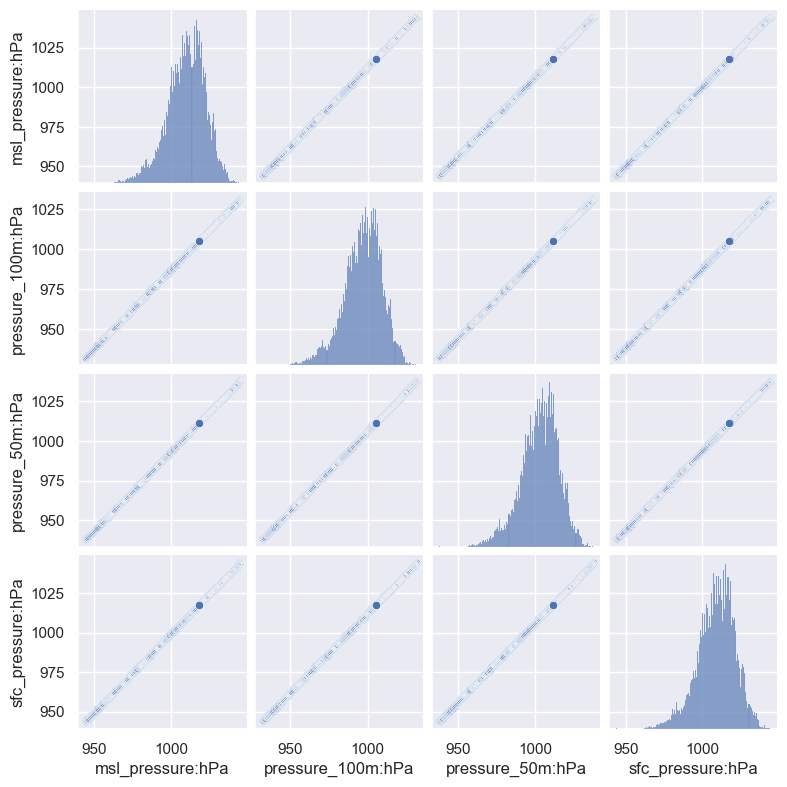

In [9]:
sns.set()
cols_pressure = ['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa']
sns.pairplot(Train_datasets[0][cols_pressure], height = 2)
plt.show()

In [10]:
high_correlated_var_to_del = [
    "dew_point_2m:K",
    "clear_sky_energy_1h:J",
    "diffuse_rad_1h:J",
    "direct_rad_1h:J",
    "msl_pressure:hPa",
    "pressure_50m:hPa",
    "sfc_pressure:hPa",
    "effective_cloud_cover:p",
    "air_density_2m:kgm3"
]
for i, dataset in enumerate(Train_datasets):
    dataset = dataset.drop(columns = high_correlated_var_to_del)
    Train_datasets[i] = dataset

Goal : Get data into proper form to use it for training a maching learning algorithm
Issues : 
    1. Not same date between the three location
    2. Gap in target data
    3. Forecast data has one more feature than observed data (Forecast time)
    4. Not the same time step in observed and forcast data
  
  Ideas to solve them (simpliest ones):
    1. Reduce dataset to the most restrictive dataset
    2. Get the data from the same date previous or next year
    3. Don't take into account forecast time feature
    4. Make an average over 4hours of each feature

Try to solve problem 2

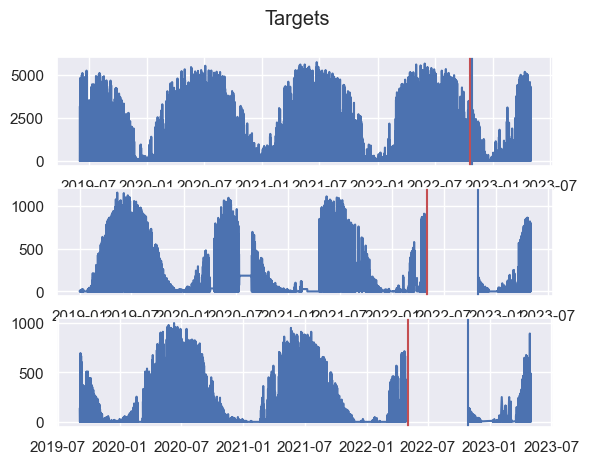

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Targets')
ax1.plot(train_a.iloc[:,0], train_a.iloc[:,1])
ax1.axvline(Train_datasets[0].iloc[-1,0],0,5000, c='r')
ax1.axvline(Train_datasets[3].iloc[0,0],0,5000, c='b')

ax2.plot(train_b.iloc[:,0], train_b.iloc[:,1])
ax2.axvline(Train_datasets[1].iloc[-1,0],0,5000, c='r')
ax2.axvline(Train_datasets[4].iloc[0,0],0,5000, c='b')

ax3.plot(train_c.iloc[:,0], train_c.iloc[:,1])
ax3.axvline(Train_datasets[2].iloc[-1,0],0,5000, c='r')
ax3.axvline(Train_datasets[5].iloc[0,0],0,5000, c='b')

plt.show()

In [12]:
location = ["A", "B", "C"]
for i in range(3):
    print("Location ", location[i])
    print("Observed data : ", Train_datasets[i].iloc[0,0]," to ", Train_datasets[i].iloc[-1,0], " ,size = ",Train_datasets[i].shape )
    print("Forecast data : ", Train_datasets[i+3].iloc[0,0]," to ", Train_datasets[i+3].iloc[-1,0],  " ,size = ",Train_datasets[i+3].shape)
    print("Target : ", Target_datasets[i].iloc[0,0]," to ", Target_datasets[i].iloc[-1,0],  " ,size = ",Target_datasets[i].shape )
    print("Missing values in target =", np.any(Target_datasets[i].isna()))
    print("Zero values in target = ", np.any(Target_datasets[i] == 0) )
    print("\n")

Location  A
Observed data :  2019-06-02 22:00:00  to  2022-10-21 01:00:00  ,size =  (118669, 36)
Forecast data :  2022-10-27 07:00:18  to  2023-04-29 07:00:05  ,size =  (17576, 37)
Target :  2019-06-02 22:00:00  to  2023-04-30 23:00:00  ,size =  (34085, 2)
Missing values in target = False
Zero values in target =  True


Location  B
Observed data :  2019-01-01 00:00:00  to  2022-05-03 00:00:00  ,size =  (116929, 36)
Forecast data :  2022-10-27 07:00:18  to  2023-04-29 07:00:05  ,size =  (17576, 37)
Target :  2018-12-31 23:00:00  to  2023-04-30 23:00:00  ,size =  (32848, 2)
Missing values in target = True
Zero values in target =  True


Location  C
Observed data :  2019-01-01 00:00:00  to  2022-05-01 22:00:00  ,size =  (116825, 36)
Forecast data :  2022-10-27 07:00:18  to  2023-04-29 07:00:05  ,size =  (17576, 37)
Target :  2018-12-31 23:00:00  to  2023-04-30 23:00:00  ,size =  (32155, 2)
Missing values in target = True
Zero values in target =  True




In [13]:
#Noe functions
def select_and_resample(Xdf: pd.DataFrame,Ydf: pd.DataFrame):
    """
    Description
    -----------
    Select and resample time series data.

    This function selects data from two time series dataframes, `Xdf` and `Ydf`, where there is a match in time values.
    It then resamples `Ydf` to a 15-minute interval using linear interpolation and returns the resulting time-aligned data.
    The output data contains only streaks of minutes `[15, 30, 45, 00]`.

    Parameters
    ----------
    - `Xdf` (pandas.DataFrame): The first time series dataframe containing `'date_forecast'` column.
    - `Ydf` (pandas.DataFrame): The second time series dataframe containing `'time'` column.

    Returns
    -------
    - Tuple of two pandas DataFrames:
      - The selected and filtered X values, with a 15-minute interval.
      - The resampled Y values, matching the selected X values.

    Example
    -------
    ```python
    Xdf = pd.DataFrame({'date_forecast': pd.date_range(start='2023-01-01', periods=100, freq='15T')})
    Ydf = pd.DataFrame({'time': pd.date_range start='2023-01-01', periods=200, freq='30T')})
    selected_X, selected_Y = select_and_resample(Xdf, Ydf)
    ```
    """
    
    ##### Select Y values where there are X values :
    Y_in_X_times = Ydf['time'].isin(Xdf['date_forecast'])
    Selected_Y = Ydf[Y_in_X_times].reset_index(drop=True)
    
    ##### Select X values where there are Y values
    # ceil the date forecast to the hour in Xdf
    Xdf['hourly_forecast'] = Xdf['date_forecast'].dt.ceil('H')
    X_in_Y_times = Xdf['hourly_forecast'].isin(Selected_Y['time'])
    Selected_X = Xdf[X_in_Y_times].reset_index(drop=True).drop(columns=['hourly_forecast'])

    #### Filter X values to get 4 consecutive 15 minutes
    valid_minutes = [15, 30, 45, 0]
    # Calculate the difference in minutes between consecutive rows
    Selected_X = Selected_X.sort_values('date_forecast')
    Selected_X['minute_diff'] = Selected_X['date_forecast'].diff().dt.total_seconds() / 60
    # Create a mask to identify valid minutes
    valid_mask = Selected_X['minute_diff'].isin(valid_minutes)
    # Create a mask to identify the start of consecutive valid minute streaks
    streak_start_mask = valid_mask & (~valid_mask.shift(1, fill_value=False))
    # Create a mask to identify the end of consecutive valid minute streaks
    streak_end_mask = valid_mask & (~valid_mask.shift(-1, fill_value=False))
    # Merge the start and end masks to get the full streak mask
    consecutive_streak_mask = streak_start_mask | streak_end_mask
    # Extend the streaks to include isolated values
    consecutive_streak_mask = consecutive_streak_mask | consecutive_streak_mask.shift(1, fill_value=False) | consecutive_streak_mask.shift(-1, fill_value=False)
    # Repeatedly extend the streaks until no more can be extended
    while True:
        extended_streaks = consecutive_streak_mask | consecutive_streak_mask.shift(1, fill_value=False) | consecutive_streak_mask.shift(-1, fill_value=False)
        if extended_streaks.equals(consecutive_streak_mask):
            break
        consecutive_streak_mask = extended_streaks
    # Identify the cases where the streaks start with non-15 minutes
    non_15_start = valid_mask & (streak_start_mask | streak_end_mask)
    consecutive_streak_mask = consecutive_streak_mask | non_15_start

    Selected_X_filtered = Selected_X[consecutive_streak_mask].drop(columns='minute_diff')

    #### Resample Ydf with 15 minute interval 
    Selected_Y.set_index('time', inplace=True)
    Selected_Y_resampled = Selected_Y.resample('15T').interpolate(method='linear') #  use 'nearest' for flatter interpolation
    Selected_Y_resampled = Selected_Y_resampled.reset_index()

    # Select Y resampled values where there are X values :
    Y_in_X_times_resampled = Selected_Y_resampled['time'].isin(Selected_X_filtered['date_forecast'])
    Selected_Y = Selected_Y_resampled[Y_in_X_times_resampled].reset_index(drop=True)
    # Again the other way round to remove data that passed through the filter
    Selected_X = Selected_X_filtered[Selected_X_filtered['date_forecast'].isin(Selected_Y['time'])].reset_index(drop=True)


    return(Selected_X[1:], Selected_Y[1:])  # remove first row which always starts with a 00

def remove_consecutive_identical_values(df: pd.DataFrame, feature: str):
    """
    Description
    -----------
    Remove rows with consecutive identical values in a specified feature of a DataFrame.

    Paramters
    ---------
    - `df` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature in the DataFrame.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with consecutive identical values removed.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time': pd.date_range(start='2023-01-01', periods=100, freq='15T'),
            'value': [1, 2, 2, 3, 3, 3, 4, 4, 4, 4]}

    df = pd.DataFrame(data)
    feature = 'value'

    filtered_df = remove_consecutive_identical_values(df, feature)
    ```
    """
    # Identify rows with consecutive identical values in the specified feature
    mask = df[feature] != df[feature].shift(+1)

    # Filter and remove rows with consecutive identical values
    filtered_df = df[mask]

    return filtered_df

def remove_consecutive_identical_values_keep_zeros(df: pd.DataFrame, feature: str):
    """
    Description
    -----------
    Remove rows with consecutive identical values (excluding 0) in a specified feature of a DataFrame.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to process.
    - `feature` (str): The name of the feature in the DataFrame.

    Returns
    -------
    - `pandas.DataFrame`: The filtered DataFrame with consecutive identical values (excluding 0) removed.

    Example
    -------
    ```python
    import pandas as pd

    data = {'time': pd.date_range(start='2023-01-01', periods=100, freq='15T'),
            'value': [1, 2, 2, 3, 3, 3, 4, 4, 0, 0, 0, 4, 4]}

    df = pd.DataFrame(data)
    feature = 'value'

    filtered_df = remove_consecutive_identical_values(df, feature)
    ```
    """
    # Identify rows with consecutive identical values in the specified feature
    mask = (df[feature] != df[feature].shift(+1)) | (df[feature] == 0)

    # Filter and remove rows with consecutive identical values, excluding 0
    filtered_df = df[mask]

    return filtered_df


def lagged_features(df):
    # Define the time intervals for retardation
    time_intervals = [15, 30, 45]

    # Create a new DataFrame to store the lagged features
    new_df = df.copy()

    # Loop through the time intervals and create lagged features
    for interval in time_intervals:
        # Create a suffix for the column names
        suffix = '__r' + str(interval)

        # Loop through the columns in the original DataFrame
        for column in df.columns:
            # Exclude the 'date_forecast' and 'date_calc' columns
            if column not in ['date_forecast', 'date_calc']:
                # Shift the values by the specified time interval
                new_df[column + suffix] = new_df[column].copy().shift(periods=interval//15)

    # Fill missing values with the last known value for each specific column
    for column in new_df.columns:
        fill_nan(new_df,column)

    return new_df


def normalize_dataframe(df: pd.DataFrame,verbose = False):
    normalized_df = df.copy()
    # Define the range [-1, 1]
    min_range = -1
    max_range = 1
    
    # Iterate over each column and apply min-max scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype]:
            min_val = normalized_df[column].min()
            max_val = normalized_df[column].max()
            if verbose:
                print(f"min:{min_val:.2f}\tmax:{max_val:.2f}")
                print(f"different:{min_val!=max_val}")
            # Normalize the non-datetime column between -1 and 1
            if min_val!=max_val:
                normalized_df[column] = min_range + (max_range - min_range) * (normalized_df[column] - min_val) / (max_val - min_val)
            else :
                normalized_df[column] = min_range + (max_range - min_range) * normalized_df[column]/max(max_val,1)

    return normalized_df

def normalize_dataframe_TEST(train_df: pd.DataFrame,test_df: pd.DataFrame,verbose = False):
    normalized_df = test_df.copy()
    # Define the range [-1, 1]
    min_range = -1
    max_range = 1
    
    # Iterate over each column and apply min-max scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype]:
            min_val = train_df[column].min()
            max_val = train_df[column].max()
            if verbose:
                print(f"min:{min_val:.2f}\tmax:{max_val:.2f}")
                print(f"different:{min_val!=max_val}")
            # Normalize the non-datetime column between -1 and 1
            if min_val!=max_val:
                normalized_df[column] = min_range + (max_range - min_range) * (normalized_df[column] - min_val) / (max_val - min_val)
            else :
                normalized_df[column] = min_range + (max_range - min_range) * normalized_df[column]/max(max_val,1)

    return normalized_df


def create_time_series_sequences(X, Y, T):
    """
    Reshape 2D data and its corresponding target into 3D sequences for time series forecasting.

    Parameters:
    - X: 2D NumPy array with dimensions (N, M), where N is the number of time samples
         and M is the number of features.
    - Y: 2D NumPy array with dimensions (N, 1), containing the target values.
    - T: Number of time steps in each sequence.

    Returns:
    - X_sequences: 3D NumPy array with dimensions (N - T, T, M), containing input sequences.
    - Y_targets: 2D NumPy array with dimensions (N - T, 1), containing corresponding targets.
    """
    N, M = X.shape

    # Initialize empty lists to store the input sequences and corresponding targets
    X_sequences = []
    Y_targets = []

    # Create sequences and targets
    for i in range(N - T):
        X_sequences.append(X[i:i + T, :])   # Create sequences of length T
        Y_targets.append(Y[i + T])          # Corresponding target

    # Convert the lists to NumPy arrays
    X_sequences = np.array(X_sequences)
    Y_targets = np.array(Y_targets)

    return X_sequences, Y_targets

In [16]:
from datetime import datetime, timedelta

#Select a location in observed dataset
location = 0 # 0=A, 1=B, 2=C
X_train_obs, X_train_est, Y_train = Train_datasets[location], Train_datasets[location+3], Target_datasets[location]

X_train_obs = X_train_obs.rename(columns={"date_forecast":"time"})
X_train_est = X_train_est.rename(columns={"date_forecast":"time"})

# truncate datasets
time_start = max(X_train_obs['time'][0], Y_train['time'][0])
end_start = min(X_train_est['time'][X_train_est.shape[0]-1],Y_train['time'][Y_train.shape[0]-1])



In [17]:
#select corresponding data
X_train_obs = X_train_obs[(X_train_obs['time'] > time_start) & (X_train_obs['time'] < end_start)]
X_train_est = X_train_est[(X_train_est['time'] > time_start) & (X_train_est['time'] < end_start)]
Y_train = Y_train[(Y_train['time'] > time_start) & (Y_train['time'] < end_start)]

#Date to cut between obs and est
end_obs_date = X_train_obs["time"][ X_train_obs.shape[0]-1]
start_est_date = X_train_est['time'][0] 

#Gaps target
# Take the diff of the first column (drop 1st row since it's undefined)
deltas = Y_train['time'].diff()[1:]

# Filter diffs (here days > 1, but could be seconds, hours, etc)
gaps = deltas[deltas > timedelta(hours=1)]
gaps_list = []

# Print results
print(f'{len(gaps)} gaps with average gap duration: {gaps.mean()}')
for i, g in gaps.iteritems():
    gap_start = Y_train['time'][i - 1]
    print(f'Start: {datetime.strftime(gap_start, "%Y-%m-%d")} | '
          f'Duration: {str(g.to_pytimedelta())}')
    gaps_list.append((gap_start, gap_start+g))


#Fill target 
fill_nan(Y_train,'pv_measurement')

#Cut between observed and estimate target
Y_obs = Y_train.loc[Y_train['time']< str(end_obs_date)]
Y_est = Y_train.loc[Y_train['time']> str(start_est_date)]


1 gaps with average gap duration: 7 days 22:00:00
Start: 2022-10-21 | Duration: 7 days, 22:00:00


In [18]:
X_train_obs = X_train_obs.rename(columns={"time":"date_forecast"})
X_train_est = X_train_est.rename(columns={"time":"date_forecast"})

X_Train_obs,Y_Train_obs = select_and_resample(X_train_obs,Y_obs)
X_Train_est,Y_Train_est = select_and_resample(X_train_est,Y_est)

print(X_Train_est.shape[0] == Y_Train_est.shape[0])
print(X_Train_obs.shape[0] == Y_Train_obs.shape[0])

True
True


Two models : One for observed data, One for estimated data, then neural network to weithed prediction of each

-LSTM for observed data to learn time trend  
-Basic neural network for estimated data to learn weighted the feature  
-Simple neural network with one layer to wiethed prediction of the two previous one  


## LSTM
predict current power using weather condition and power at prior step

In [20]:
# convert series to supervised learning
def series_to_supervised(data,Name_features, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s %d(t-%d)' % (Name_features[j],j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s %d(t)' % (Name_features[j],j+1)) for j in range(n_vars)]
        else:
            names += [('%s %d(t+%d)' % (Name_features[j],j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    return agg



# Define a function to create and train an LSTM model
def create_lstm_model(input_shape, nbr_unit):
    model = Sequential()
    model.add(LSTM(units= nbr_unit, activation='relu', input_shape=input_shape,
            kernel_regularizer=l1(0.01), recurrent_regularizer=l1(0.01), bias_regularizer=l1(0.01)
                ))
    model.add(Dense(1, kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01)))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_MLP_model(nb_feature):
    model = Sequential()
    model.add(Dense(nb_feature, kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01), activation = 'relu'))
    model.add(Dense(1, activation = 'linear',kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01)))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define a function to create input and output sequences for the LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [65]:
#Transform panda into dataset with lag

#Add y data at the end
Dataframe = X_Train_obs.drop(columns=['date_forecast'])
Name_features = Dataframe.columns

values = Dataframe.values
values = values.astype('float32')

n_in = 2 # Number of lag observations as input
n_out = 1#Number of observations as output (y)

# frame as supervised learning
reframed = series_to_supervised(values,Name_features, n_in, n_out)

#Add pv_measurement at the end as target
#reframed = pd.concat((reframed,Y_Train_obs.reset_index().iloc[:,2]), axis=1)

nan_features = [var for var in reframed.columns if reframed[var].isnull().sum() > 0]

for features in nan_features:
    fill_nan(reframed, features)
    print("\n")
    
#Save dataframe before normalization for reference
reference_dataset = pd.concat([X_Train_obs['date_forecast'].reset_index(),reframed.copy()], axis=1, ignore_index=True)
reference_dataset = reference_dataset.drop(reference_dataset.columns[0], axis=1)
reference_dataset.columns= reframed.columns.insert(0,'date_forecast')

#Normalization
values = reframed.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = pd.DataFrame(scaled, columns=reframed.columns)


==>  absolute_humidity_2m:gm3 1(t-2)  filled with  bfill  method


==>  air_density_2m:kgm3 2(t-2)  filled with  bfill  method


==>  ceiling_height_agl:m 3(t-2)  filled with  bfill  method


==>  clear_sky_rad:W 4(t-2)  filled with  bfill  method


==>  cloud_base_agl:m 5(t-2)  filled with  bfill  method


==>  dew_or_rime:idx 6(t-2)  filled with  bfill  method


==>  diffuse_rad:W 7(t-2)  filled with  bfill  method


==>  direct_rad:W 8(t-2)  filled with  bfill  method


==>  effective_cloud_cover:p 9(t-2)  filled with  bfill  method


==>  elevation:m 10(t-2)  filled with  bfill  method


==>  fresh_snow_12h:cm 11(t-2)  filled with  bfill  method


==>  fresh_snow_1h:cm 12(t-2)  filled with  bfill  method


==>  fresh_snow_24h:cm 13(t-2)  filled with  bfill  method


==>  fresh_snow_3h:cm 14(t-2)  filled with  bfill  method


==>  fresh_snow_6h:cm 15(t-2)  filled with  bfill  method


==>  is_day:idx 16(t-2)  filled with  bfill  method


==>  is_in_shadow:idx 17(t-2)  filled with  b

In [66]:
reframed

,absolute_humidity_2m:gm3 1(t-2),air_density_2m:kgm3 2(t-2),ceiling_height_agl:m 3(t-2),clear_sky_rad:W 4(t-2),cloud_base_agl:m 5(t-2),dew_or_rime:idx 6(t-2),diffuse_rad:W 7(t-2),direct_rad:W 8(t-2),effective_cloud_cover:p 9(t-2),elevation:m 10(t-2),...,sun_azimuth:d 28(t),sun_elevation:d 29(t),super_cooled_liquid_water:kgm2 30(t),t_1000hPa:K 31(t),total_cloud_cover:p 32(t),visibility:m 33(t),wind_speed_10m:ms 34(t),wind_speed_u_10m:ms 35(t),wind_speed_v_10m:ms 36(t),wind_speed_w_1000hPa:ms 37(t)
0,0.416667,0.280142,0.135472,0.0,0.142898,0.5,0.0,0.0,0.997,0.0,...,0.000647,0.455646,0.0,0.630630,1.000,0.509482,0.223684,0.198980,0.530726,0.0
1,0.416667,0.280142,0.135472,0.0,0.142898,0.5,0.0,0.0,0.997,0.0,...,0.010350,0.456236,0.0,0.630630,1.000,0.435163,0.217105,0.204082,0.541899,0.0
2,0.416667,0.280142,0.135472,0.0,0.142898,0.5,0.0,0.0,0.997,0.0,...,0.020045,0.457836,0.0,0.632883,1.000,0.360489,0.210526,0.209184,0.547486,0.0
3,0.416667,0.276596,0.134732,0.0,0.142117,0.5,0.0,0.0,0.998,0.0,...,0.027053,0.460926,0.0,0.632883,1.000,0.285393,0.210526,0.214286,0.558659,0.0
4,0.416667,0.273050,0.134025,0.0,0.141371,0.5,0.0,0.0,0.999,0.0,...,0.036695,0.464276,0.0,0.632883,1.000,0.221049,0.203947,0.219388,0.558659,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118655,0.273810,0.503546,0.102734,0.0,0.010428,0.5,0.0,0.0,0.089,0.0,...,0.998158,0.131816,0.0,0.414414,0.055,0.392381,0.085526,0.372449,0.592179,0.0
118656,0.273810,0.507092,0.102734,0.0,0.010428,0.5,0.0,0.0,0.072,0.0,...,0.010983,0.132296,0.0,0.412163,0.049,0.382931,0.085526,0.367347,0.592179,0.0
118657,0.273810,0.510638,0.102734,0.0,0.010428,0.5,0.0,0.0,0.055,0.0,...,0.023784,0.134136,0.0,0.409910,0.042,0.374759,0.085526,0.362245,0.592179,0.0
118658,0.267857,0.514184,0.102734,0.0,0.010428,0.5,0.0,0.0,0.049,0.0,...,0.036514,0.137296,0.0,0.407658,0.035,0.367457,0.085526,0.352041,0.592179,0.0


In [117]:
#Get data into proper shape for LSTM

#Split train/test
values = reframed.values
split = int(reframed.shape[0]*0.8)
train_X = values[:split, :]
test_X = values[split:, :]

train_y = Y_Train_obs.reset_index().iloc[:,2].values[:split]
test_y = Y_Train_obs.reset_index().iloc[:,2].values[split:]


# reshape input to be 3D [samples, timesteps, features]
nb_feature = X_Train_obs.shape[1]-1
train_X_LSTM = np.zeros((train_X.shape[0],n_in+1,nb_feature))
test_X_LSTM  = np.zeros((test_X.shape[0],n_in+1,nb_feature))

# Fill to to be 3D [samples, timesteps, features]
for i in range(nb_feature):
    for j in range(n_in+1):
        train_X_LSTM[:,j,i] = train_X[:,i +j*nb_feature]
        test_X_LSTM[:,j,i]  = test_X[:,i +j*nb_feature]


""" 
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
"""
print(train_X_LSTM.shape, train_y.shape, test_X_LSTM.shape, test_y.shape)

(94928, 3, 37) (94928,) (23732, 3, 37) (23732,)


In [119]:
#LSTM 
model = Sequential()
model.add(LSTM(units= train_X_LSTM.shape[2], activation='relu', input_shape=(train_X_LSTM.shape[1], train_X_LSTM.shape[2]),
            kernel_regularizer=l1(0.01), recurrent_regularizer=l1(0.01), bias_regularizer=l1(0.01)
            ))
model.add(Dense(64, kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01), activation ='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01), activation ='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, mode = "min", verbose=1,
                                                  restore_best_weights = True, start_from_epoch = 50)
model.compile(optimizer='adam', loss='mean_squared_error')

In [120]:
#Simple training for the moment without timeseriesplit
history = model.fit(train_X_LSTM, train_y, epochs=100, batch_size=128, validation_data=(test_X_LSTM, test_y),
                    callbacks=[early_stopping], verbose=2, shuffle=False)

Epoch 1/100
742/742 - 5s - loss: 614457.8750 - val_loss: 392894.9688 - 5s/epoch - 6ms/step
Epoch 2/100
742/742 - 3s - loss: 255405.5156 - val_loss: 373146.4375 - 3s/epoch - 4ms/step
Epoch 3/100
742/742 - 3s - loss: 241599.0781 - val_loss: 362524.6562 - 3s/epoch - 4ms/step
Epoch 4/100
742/742 - 3s - loss: 236524.6406 - val_loss: 363583.3125 - 3s/epoch - 4ms/step
Epoch 5/100
742/742 - 3s - loss: 235448.1562 - val_loss: 369801.8750 - 3s/epoch - 4ms/step
Epoch 6/100
742/742 - 3s - loss: 234062.9219 - val_loss: 372965.9375 - 3s/epoch - 4ms/step
Epoch 7/100
742/742 - 3s - loss: 232303.9219 - val_loss: 371094.8750 - 3s/epoch - 4ms/step
Epoch 8/100
742/742 - 3s - loss: 230939.8750 - val_loss: 377892.8125 - 3s/epoch - 4ms/step
Epoch 9/100
742/742 - 3s - loss: 230187.8594 - val_loss: 374733.4375 - 3s/epoch - 4ms/step
Epoch 10/100
742/742 - 3s - loss: 231131.1250 - val_loss: 376056.8438 - 3s/epoch - 4ms/step
Epoch 11/100
742/742 - 3s - loss: 230274.7031 - val_loss: 379139.8438 - 3s/epoch - 4ms/st

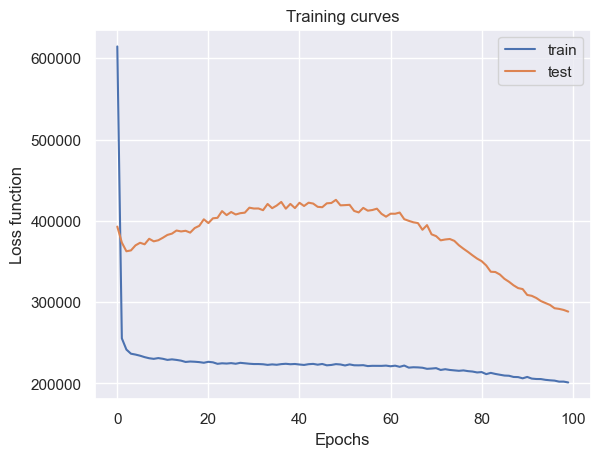

In [122]:
# plot history
plt.title("Training curves")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss function")
plt.legend()
plt.show()

In [124]:
# make a prediction
yhat = model.predict(test_X_LSTM)
yhat[yhat<0] = 0

# calculate RMSE
mae = mean_absolute_error(test_y, yhat)
print('Test MAE:', mae)

742/742 [==============================] - 1s 2ms/step
Test MAE: 288.0321270446102


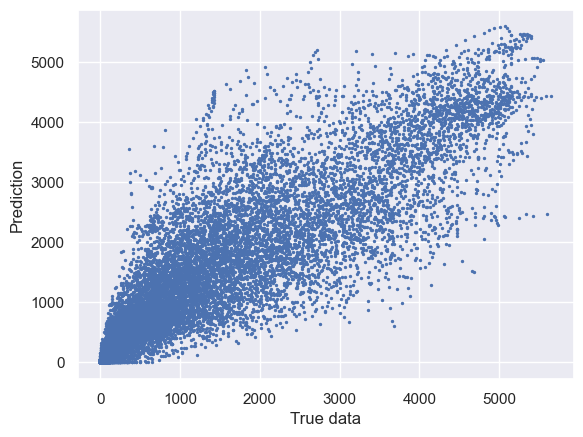

In [125]:
plt.scatter(test_y, yhat, s=2)
plt.xlabel("True data")
plt.ylabel("Prediction")
plt.show()

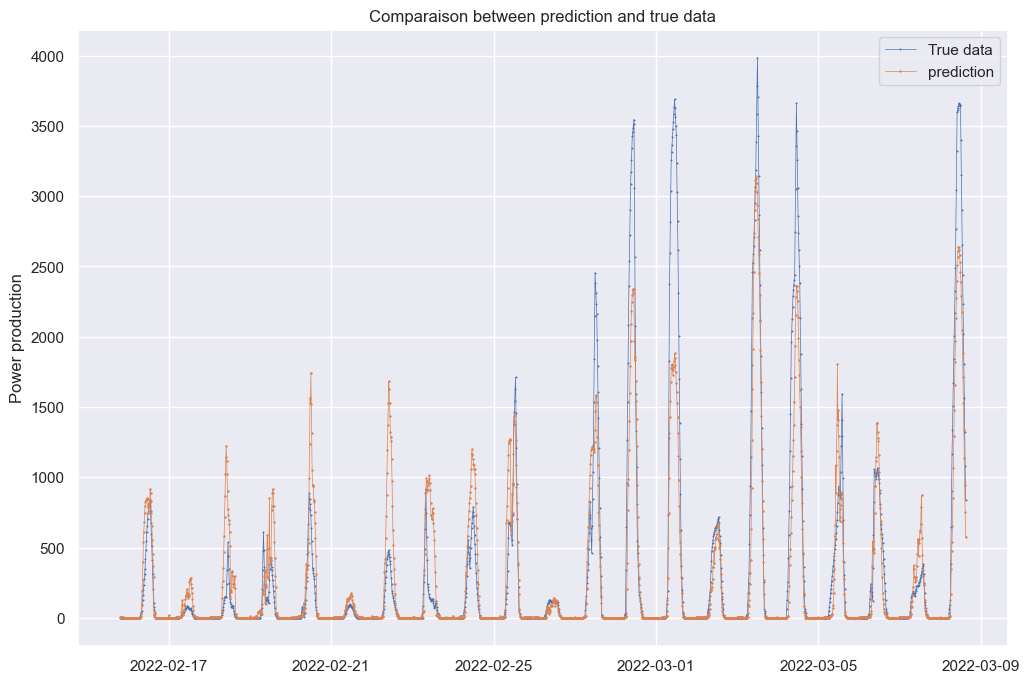

In [79]:
zoom = 2000
plt.figure(figsize=(12,8))
plt.title("Comparaison between prediction and true data")
plt.plot(reference_dataset.iloc[split:split+zoom,0],test_y[0:zoom], '-*',linewidth = 0.5, markersize = 0.8, label='True data')
plt.plot(reference_dataset.iloc[split:split+zoom,0],yhat[0:zoom],'-+',linewidth = 0.5, markersize = 0.8, label='prediction')
plt.ylabel("Power production")
plt.legend()
plt.show()

Classic neural network

In [81]:
#Split train and test data
values = reframed.values
split = int(reframed.shape[0]*0.8)
train_X = values[:split, :]
test_X = values[split:, :]

train_y = Y_Train_obs.reset_index().iloc[:,2].values[:split]
test_y = Y_Train_obs.reset_index().iloc[:,2].values[split:]

In [82]:
#Model Architecture
model2 = Sequential()
model2.add(Dense(train_X.shape[1], input_shape=(train_X.shape[1],),kernel_regularizer=l1(0.01), 
        bias_regularizer=l1(0.01), activation = 'relu')
        )
model2.add(Dense(256,kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01), activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(128,kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01), activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(64,kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01), activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(32,kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01), activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01), activation = 'linear'))

#Method to stop learning when there is no improvement
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, mode = "min", verbose=1,
                                                  restore_best_weights = True, start_from_epoch = 50)
model2.compile(optimizer='adam', loss='mean_squared_error')

#MLP Model training
history = model2.fit(train_X, train_y, epochs=500, batch_size=128, validation_data=(test_X, test_y), verbose=2,
                callbacks=[early_stopping], shuffle=False
                )

Epoch 1/500
742/742 - 4s - loss: 489572.6562 - val_loss: 332809.6875 - 4s/epoch - 6ms/step
Epoch 2/500
742/742 - 3s - loss: 278599.8750 - val_loss: 335566.6250 - 3s/epoch - 4ms/step
Epoch 3/500
742/742 - 3s - loss: 269258.7188 - val_loss: 365618.0625 - 3s/epoch - 4ms/step
Epoch 4/500
742/742 - 3s - loss: 265344.1250 - val_loss: 389154.5312 - 3s/epoch - 4ms/step
Epoch 5/500
742/742 - 3s - loss: 265583.4375 - val_loss: 408697.9062 - 3s/epoch - 4ms/step
Epoch 6/500
742/742 - 3s - loss: 264392.7188 - val_loss: 427219.0312 - 3s/epoch - 4ms/step
Epoch 7/500
742/742 - 3s - loss: 257864.4531 - val_loss: 476088.8125 - 3s/epoch - 4ms/step
Epoch 8/500
742/742 - 4s - loss: 263553.6250 - val_loss: 421892.4062 - 4s/epoch - 5ms/step
Epoch 9/500
742/742 - 4s - loss: 260591.0000 - val_loss: 440740.3438 - 4s/epoch - 5ms/step
Epoch 10/500
742/742 - 4s - loss: 259500.7656 - val_loss: 496876.2500 - 4s/epoch - 5ms/step
Epoch 11/500
742/742 - 4s - loss: 255972.9531 - val_loss: 474765.4062 - 4s/epoch - 5ms/st

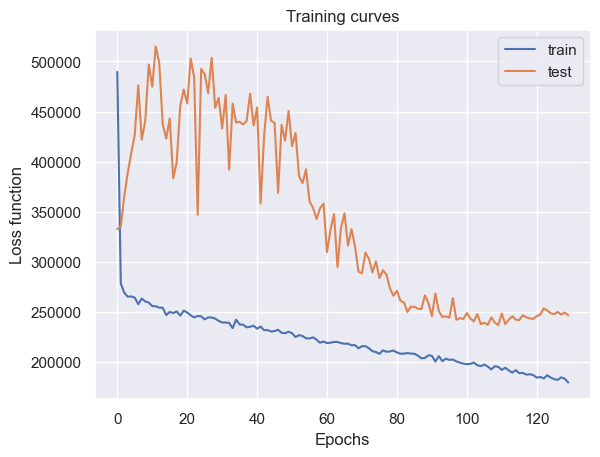

In [83]:
# plot history
plt.title("Training curves")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss function")
plt.legend()
plt.show()

742/742 [==============================] - 1s 2ms/step
Test MAE: 256.2583012737758


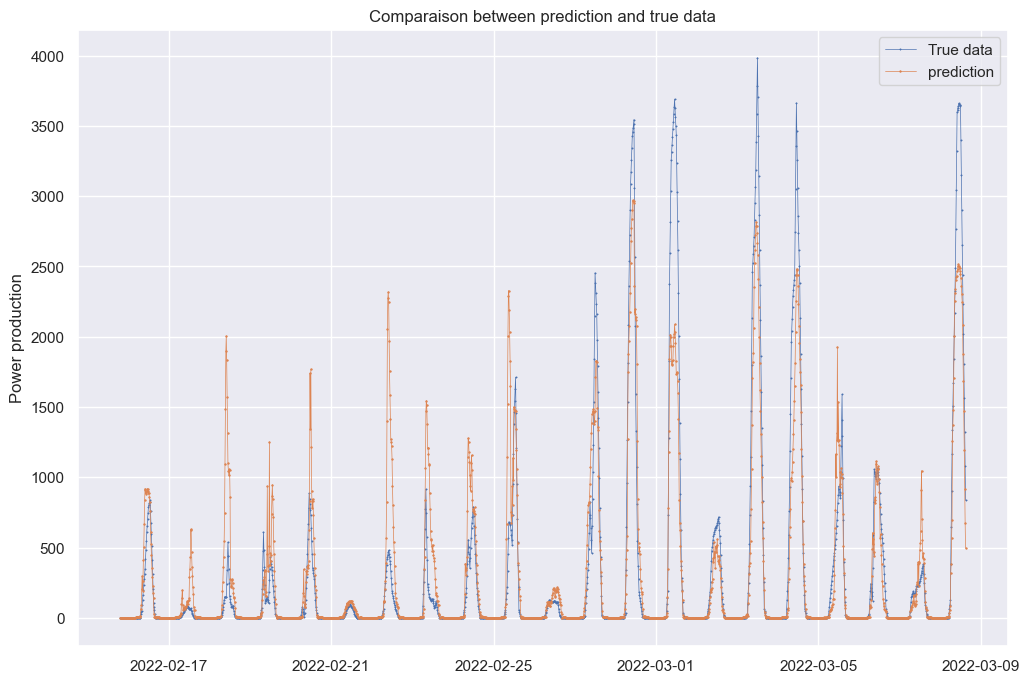

In [85]:
# make a prediction
yhat = model2.predict(test_X)
yhat[yhat<0] = 0

# calculate RMSE
mae = mean_absolute_error(test_y, yhat)
print('Test MAE:', mae)

zoom = 2000
plt.figure(figsize=(12,8))
plt.title("Comparaison between prediction and true data")
plt.plot(reference_dataset.iloc[split:split+zoom,0],test_y[0:zoom], '-*',linewidth = 0.5, markersize = 0.8, label='True data')
plt.plot(reference_dataset.iloc[split:split+zoom,0],yhat[0:zoom],'-+',linewidth = 0.5, markersize = 0.8, label='prediction')
plt.ylabel("Power production")
plt.legend()
plt.show()

CNN 

In [97]:
model3 = Sequential()
model3.add(InputLayer((train_X.shape[1],1)))
model3.add(Conv1D(train_X.shape[1], kernel_size=5))
model3.add(Flatten())
model3.add(Dense(16, activation ='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation ='linear'))
model3.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, mode = "min", verbose=1,
                                                  restore_best_weights = True, start_from_epoch = 50)
model3.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 107, 111)          666       
                                                                 
 flatten_4 (Flatten)         (None, 11877)             0         
                                                                 
 dense_37 (Dense)            (None, 16)                190048    
                                                                 
 dropout_20 (Dropout)        (None, 16)                0         
                                                                 
 dense_38 (Dense)            (None, 1)                 17        
                                                                 
Total params: 190731 (745.04 KB)
Trainable params: 190731 (745.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [93]:
#MLP Model training
history = model3.fit(train_X, train_y, epochs=500, batch_size=128, validation_data=(test_X, test_y), verbose=2,
                callbacks=[early_stopping], shuffle=False
                )

Epoch 1/500
742/742 - 14s - loss: 815256.0000 - val_loss: 624032.6250 - 14s/epoch - 19ms/step
Epoch 2/500
742/742 - 14s - loss: 287205.8438 - val_loss: 363902.5000 - 14s/epoch - 18ms/step
Epoch 3/500
742/742 - 14s - loss: 246471.0469 - val_loss: 393588.1562 - 14s/epoch - 19ms/step
Epoch 4/500
742/742 - 15s - loss: 239915.0000 - val_loss: 408972.4062 - 15s/epoch - 20ms/step
Epoch 5/500
742/742 - 15s - loss: 239301.1719 - val_loss: 416833.8438 - 15s/epoch - 21ms/step
Epoch 6/500
742/742 - 15s - loss: 240025.2812 - val_loss: 405218.6875 - 15s/epoch - 21ms/step
Epoch 7/500
742/742 - 15s - loss: 239426.4219 - val_loss: 389060.3750 - 15s/epoch - 20ms/step
Epoch 8/500
742/742 - 15s - loss: 239777.6562 - val_loss: 384759.5938 - 15s/epoch - 20ms/step
Epoch 9/500
742/742 - 15s - loss: 238145.6094 - val_loss: 377570.5000 - 15s/epoch - 20ms/step
Epoch 10/500
742/742 - 15s - loss: 237714.5469 - val_loss: 369041.1562 - 15s/epoch - 21ms/step
Epoch 11/500
742/742 - 23s - loss: 236672.6094 - val_loss: 

KeyboardInterrupt: 

In [129]:
X_Train_obs

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,diffuse_rad:W,direct_rad:W,effective_cloud_cover:p,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
1,2019-06-02 23:15:00,7.7,1.224,1694.199951,0.0,1694.199951,0.0,0.0,0.0,99.699997,...,0.235000,-4.438000,0.0,286.899994,100.0,36427.199219,3.4,-3.4,0.2,-0.0
2,2019-06-02 23:30:00,7.7,1.223,1685.099976,0.0,1685.099976,0.0,0.0,0.0,99.800003,...,3.728000,-4.379000,0.0,286.899994,100.0,31136.000000,3.3,-3.3,0.4,-0.0
3,2019-06-02 23:45:00,7.7,1.222,1676.400024,0.0,1676.400024,0.0,0.0,0.0,99.900002,...,7.218000,-4.219000,0.0,287.000000,100.0,25819.500000,3.2,-3.2,0.5,-0.0
4,2019-06-03 00:00:00,7.7,1.221,1668.099976,0.0,1668.099976,0.0,0.0,0.0,100.000000,...,9.741000,-3.910000,0.0,287.000000,100.0,20473.000000,3.2,-3.1,0.7,-0.0
5,2019-06-03 00:15:00,7.8,1.220,1598.199951,0.0,1598.199951,0.0,0.0,0.0,100.000000,...,13.212000,-3.575000,0.0,287.000000,100.0,15892.000000,3.1,-3.0,0.7,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118656,2022-10-20 23:00:00,5.3,1.289,1291.500000,0.0,149.500000,0.0,0.0,0.0,5.500000,...,359.334991,-36.821999,0.0,277.299988,5.5,28090.099609,1.3,-0.0,1.3,-0.0
118657,2022-10-20 23:15:00,5.2,1.290,1291.500000,0.0,149.500000,0.0,0.0,0.0,4.900000,...,3.956000,-36.773998,0.0,277.200012,4.9,27417.300781,1.3,-0.1,1.3,-0.0
118658,2022-10-20 23:30:00,5.2,1.291,1291.500000,0.0,149.500000,0.0,0.0,0.0,4.200000,...,8.564000,-36.590000,0.0,277.100006,4.2,26835.500000,1.3,-0.2,1.3,-0.0
118659,2022-10-20 23:45:00,5.1,1.292,1291.500000,0.0,149.500000,0.0,0.0,0.0,3.500000,...,13.147000,-36.273998,0.0,277.000000,3.5,26315.599609,1.3,-0.4,1.3,-0.0


In [216]:
Dataset = pd.concat((Y_Train_obs, X_Train_obs), axis=1)
Dataset['hour'] = Dataset['date_forecast'].dt.hour
Dataset = Dataset.drop(columns=['time', 'date_forecast'])

#Split train/test
test_split=round(0.8*X_train_obs.shape[0])
df_for_training=Dataset[0:test_split]
df_for_testing=Dataset[test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

#Scaled
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training.values)
df_for_testing_scaled=scaler.transform(df_for_testing.values)

#Shape dataset for LSTM input
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(df_for_training_scaled,4)
testX,testY=createXY(df_for_testing_scaled,4)

print(trainX.shape)
print(testX.shape)

(94934, 39)
(23726, 39)
(94930, 4, 38)
(23722, 4, 38)


In [217]:
#LSTM 
model4 = Sequential()
model4.add(LSTM(units= trainX.shape[2], return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model4.add(LSTM(units = 50))
model4.add(Dropout(0.2))
model4.add(Dense(16, activation ='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(1, activation ='linear'))

model4.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = "min", verbose=1,
                                                  restore_best_weights = False, start_from_epoch = 20)
model4.compile(optimizer='adam', loss='mean_squared_error')

In [218]:
history = model4.fit(trainX, trainY, epochs=500, batch_size=128, validation_data=(testX, testY), verbose=2,
                callbacks=[early_stopping], shuffle=False
                )

Epoch 1/500
742/742 - 9s - loss: 0.0117 - val_loss: 0.0123 - 9s/epoch - 12ms/step
Epoch 2/500
742/742 - 5s - loss: 0.0089 - val_loss: 0.0102 - 5s/epoch - 7ms/step
Epoch 3/500
742/742 - 5s - loss: 0.0084 - val_loss: 0.0100 - 5s/epoch - 7ms/step
Epoch 4/500
742/742 - 5s - loss: 0.0082 - val_loss: 0.0101 - 5s/epoch - 7ms/step
Epoch 5/500
742/742 - 5s - loss: 0.0081 - val_loss: 0.0103 - 5s/epoch - 7ms/step
Epoch 6/500
742/742 - 5s - loss: 0.0079 - val_loss: 0.0106 - 5s/epoch - 7ms/step
Epoch 7/500
742/742 - 5s - loss: 0.0078 - val_loss: 0.0104 - 5s/epoch - 7ms/step
Epoch 8/500
742/742 - 5s - loss: 0.0077 - val_loss: 0.0106 - 5s/epoch - 7ms/step
Epoch 9/500
742/742 - 5s - loss: 0.0076 - val_loss: 0.0104 - 5s/epoch - 7ms/step
Epoch 10/500
742/742 - 5s - loss: 0.0075 - val_loss: 0.0103 - 5s/epoch - 7ms/step
Epoch 11/500
742/742 - 5s - loss: 0.0075 - val_loss: 0.0101 - 5s/epoch - 7ms/step
Epoch 12/500
742/742 - 6s - loss: 0.0074 - val_loss: 0.0100 - 6s/epoch - 8ms/step
Epoch 13/500
742/742 - 6

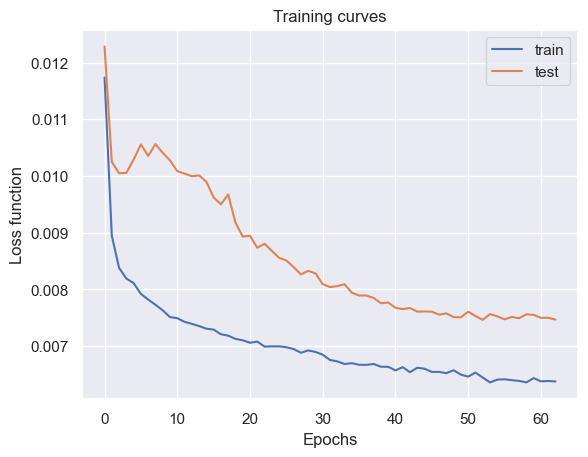

In [219]:
# plot history
plt.title("Training curves")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss function")
plt.legend()
plt.show()

742/742 [==============================] - 3s 3ms/step
Test MAE: 261.43021026285743


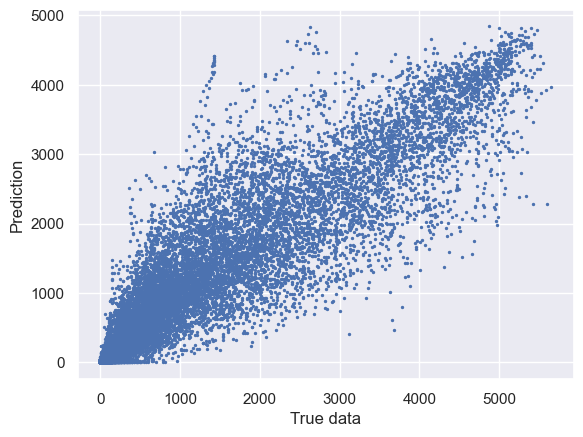

In [220]:
#Predict
prediction =model4.predict(testX)
prediction[prediction<0] = 0

#Inverse scaler
shape_copy = df_for_training.shape[1]
prediction_copies_array = np.repeat(prediction,shape_copy, axis=-1)
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),shape_copy)))[:,0]

original_copies_array = np.repeat(testY,shape_copy, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),shape_copy)))[:,0]

# calculate RMSE
mae = mean_absolute_error(original, pred)
print('Test MAE:', mae)

plt.scatter(original, pred, s=2)
plt.xlabel("True data")
plt.ylabel("Prediction")
plt.show()

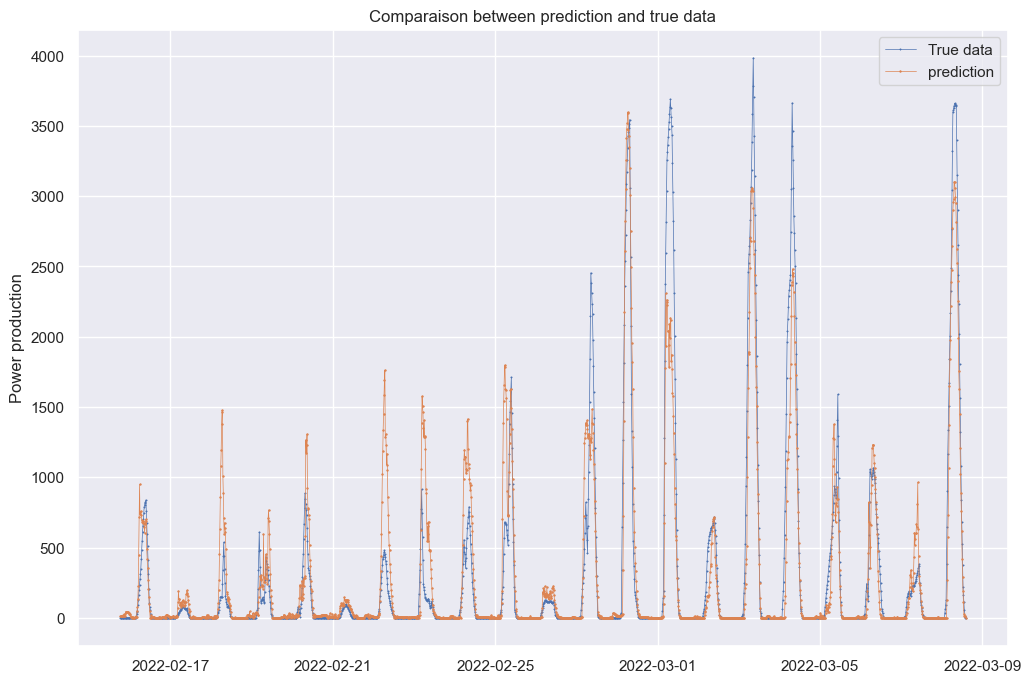

In [221]:
zoom = 2000
plt.figure(figsize=(12,8))
plt.title("Comparaison between prediction and true data")
plt.plot(X_train_obs.iloc[split:split+zoom,0],original[0:zoom], '-*',linewidth = 0.5, markersize = 0.8, label='True data')
plt.plot(X_train_obs.iloc[split:split+zoom,0],pred[0:zoom],'-+',linewidth = 0.5, markersize = 0.8, label='prediction')
plt.ylabel("Power production")
plt.legend()
plt.show()

In [86]:
def convert_datetime(df: pd.DataFrame, time_feature: str):
    new_df = df.copy()

    # Convert the 'time_feature' column to datetime if it's not already
    new_df[time_feature] = pd.to_datetime(new_df[time_feature])

    # Calculate the number of seconds since midnight and subtract it from 86400 to make it -1 at midnight
    new_df['seconds_since_midnight'] = (new_df[time_feature] - new_df[time_feature].dt.normalize()).dt.total_seconds()

    # Calculate the sine of the day with -1 at midnight
    new_df['sin_day'] = np.sin(2 * np.pi * new_df['seconds_since_midnight']/86400- np.pi/2)

    # Calculate the sine of the year with -1 on January 1st
    new_df['sin_year'] = np.sin(2 * np.pi * (new_df[time_feature].dt.dayofyear - 1)/365 - np.pi/2)

    # Calculate the cos of the year with -1 on January 1st
    new_df['cos_year'] = np.cos(2 * np.pi * (new_df[time_feature].dt.dayofyear - 1)/365 - np.pi/2)

    # Calculate the difference in seconds between 'time_feature' and 'date_calc'
    #new_df['forecast_interval'] = (new_df[time_feature] - new_df['date_calc']).dt.total_seconds().fillna(0)

    # Drop the temporary 'seconds_since_midnight' column if you don't need it
    new_df.drop('seconds_since_midnight', axis=1, inplace=True)

    return new_df

In [83]:
def normalize_dataframe_mean_std(df: pd.DataFrame,verbose = False):
    """
    Description
    -----------
    Normalize a DataFrame using mean and standard deviation scaling.

    This function performs mean and standard deviation scaling to normalize each column in the DataFrame using the
    mean and standard deviation values calculated from the same DataFrame.

    Parameters
    ----------
    - `df` (pandas.DataFrame): The DataFrame to be normalized.
    - `verbose` (bool): Whether to display information about the columns being normalized.

    Returns
    -------
    - pandas.DataFrame: A new DataFrame with columns normalized based on mean and standard deviation values.

    Example
    -------
    ```python
    import pandas as pd

    data = {'feature1': [1, 2, 3, 4, 5],
            'feature2': [10, 20, 30, 40, 50]}

    df = pd.DataFrame(data)

    normalized_df = normalize_dataframe_mean_std(df)
    ```
    """

    normalized_df = df.copy()

    # Iterate over each column and apply mean/std scaling, excluding datetime columns
    for column in normalized_df.columns:
        if verbose:
            print(column)
        if normalized_df[column].dtype not in [pd.Timestamp, pd.DatetimeTZDtype,'<M8[us]']:
            mean = normalized_df[column].mean()
            std = normalized_df[column].std()
            if verbose:
                print(f"mean:{mean:1f} \tstd:{std:.1f}")
            if std!=0:
                normalized_df[column] = (normalized_df[column] - mean) / std
            else :
                normalized_df[column] = (normalized_df[column] - mean) / 1

    return normalized_df

In [151]:
def create_lstm_data(dataframe_X,dataframe_Y, n_lag):
    '''
    input:
        data - the numpy matrix of (n, p+1) shape, where n is the number of rows,
               p+1 is the number of predictors + 1 target column
        k    - the length of the sequence, namely, the number of previous rows 
               (including current) we want to use to predict the target.
    output:
        X_data - the predictors numpy matrix of (n-k, k, p) shape
        y_data - the target numpy array of (n-k, 1) shape
    '''
    # initialize zero matrix of (n-k, k, p) shape to store the n-k number
    # of sequences of k-length and zero array of (n-k, 1) to store targets
    dataframe = pd.concat([dataframe_X,dataframe_Y], axis=1)
    data = dataframe.values
    columns = dataframe.columns

    #[sample-n_lag, n_lag, feature]
    X_data = np.zeros([data.shape[0]-n_lag, n_lag, data.shape[1]-1])
    y_data = []
    
    # run loop to slice k-number of previous rows as 1 sequence to predict
    # 1 target and save them to X_data matrix and y_data list
    for i in range(n_lag, data.shape[0]):
        cur_sequence = data[i-n_lag: i, :-1]
        cur_target = data[i-1, -1]
        
        X_data[i-n_lag,:, :] = cur_sequence.reshape(1, n_lag, X_data.shape[2])
        y_data.append(cur_target)
    
    return X_data, np.asarray(y_data)


In [132]:
#Select a location in observed dataset
location = 2 # 0=A, 1=B, 2=C
X_train_obs, X_train_est, Y_train = Train_datasets[location], Train_datasets[location+3], Target_datasets[location]

Y_train_filled = fill_nan(Y_train, 'pv_measurement')

# Select proper samples
Ydf = remove_consecutive_identical_values(Y_train_filled,'pv_measurement')
Xdf = pd.concat([X_train_obs,X_train_est]).reset_index(drop=True)
X_Train_sample,Y_Train_sample = select_and_resample(Xdf,Ydf)
print(X_Train_sample.shape[0] == Y_Train_sample.shape[0])

#Add cos time
X_Train = convert_datetime(X_Train_sample, 'date_forecast')

#Remove times columns
X_Train = X_Train_sample.drop(columns=['date_forecast','date_calc'])
n_features = X_Train.shape[1]
n_lag = 4

#Normalization
X_Train_normalized = normalize_dataframe_mean_std(X_Train)
X_Train_lags = lagged_features(X_Train_normalized)
print(X_Train_normalized.shape)
print(X_Train_lags.shape)
X_Train_normalized.describe()
Y_Train_sample.describe()

==>  pv_measurement  filled with  bfill  method


TypeError: 'NoneType' object is not subscriptable

In [116]:
#Split Train, Validation, Test
X_Train,X_Test, Y_Train, Y_Test = train_test_split(X_Train_normalized, Y_Train_sample.iloc[:,1],
                                                    test_size=0.2,
                                                    shuffle=False
                                                    )
X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_Train, Y_Train,
                                                    test_size=0.2,
                                                    shuffle=False
                                                    )

#LSTM input
X_Train_lstm, Y_Train_lstm = create_lstm_data(X_Train, Y_Train,n_lag)
X_Val_lstm , Y_Val_lstm    = create_lstm_data(X_Val, Y_Val,n_lag)
X_Test_lstm , Y_Test_lstm  = create_lstm_data(X_Test, Y_Test,n_lag)
print(X_Train_lstm.shape, Y_Train_lstm.shape)

(42628, 4, 35) (42628,)


In [131]:
Y_train

,time,pv_measurement
0,2018-12-31 23:00:00,NaN
1,2019-01-01 00:00:00,NaN
2,2019-01-01 01:00:00,NaN
3,2019-01-01 02:00:00,NaN
4,2019-01-01 03:00:00,NaN
...,...,...
32150,2023-04-30 19:00:00,50.96
32151,2023-04-30 20:00:00,2.94
32152,2023-04-30 21:00:00,0.00
32153,2023-04-30 22:00:00,-0.00


In [117]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(n_features, activation='relu',return_sequences = True, input_shape=(n_lag, n_features)))
model_LSTM.add(LSTM(units = 50,activation='relu',return_sequences = True))
model_LSTM.add(LSTM(units = 30, activation='relu'))
model_LSTM.add(Dense(16, activation ='relu'))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(1, activation ='linear'))

opt = keras.optimizers.Adam(learning_rate=0.01)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = "min", verbose=1,
                                                  restore_best_weights = False, start_from_epoch = 20)
model_LSTM.summary()

In [119]:
model_LSTM.compile(optimizer=opt, loss='mse')
history = model_LSTM.fit(x=X_Train_lstm,
                    y=Y_Train_lstm,
                    batch_size = 256, 
                    steps_per_epoch=1, 
                    epochs=500, 
                    verbose=2,
                    validation_data = [X_Val_lstm, Y_Val_lstm],
                    callbacks = [early_stopping] 
                    )

Epoch 1/500
1/1 - 7s - loss: nan - val_loss: nan - 7s/epoch - 7s/step
Epoch 2/500
1/1 - 1s - loss: nan - val_loss: nan - 775ms/epoch - 775ms/step
Epoch 3/500
1/1 - 1s - loss: nan - val_loss: nan - 797ms/epoch - 797ms/step
Epoch 4/500
1/1 - 1s - loss: nan - val_loss: nan - 801ms/epoch - 801ms/step
Epoch 5/500


KeyboardInterrupt: 

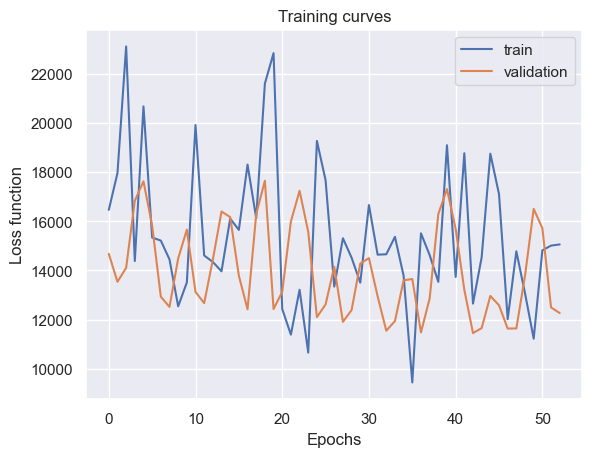

In [108]:
# plot history
plt.title("Training curves")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss function")
plt.legend()
plt.show()

336/336 [==============================] - 3s 6ms/step
mae =  53.91893643461701


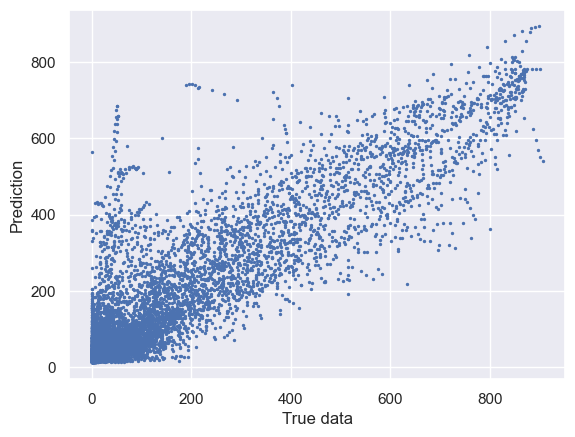

In [109]:
#Predict
prediction =model_LSTM.predict(X_Test_lstm)
prediction[prediction<0] = 0

#Evaluate
mae = mean_absolute_error(Y_Test_lstm, prediction)
print("mae = ",mae)

plt.scatter(Y_Test_lstm, prediction, s=2)
plt.xlabel("True data")
plt.ylabel("Prediction")
plt.show()

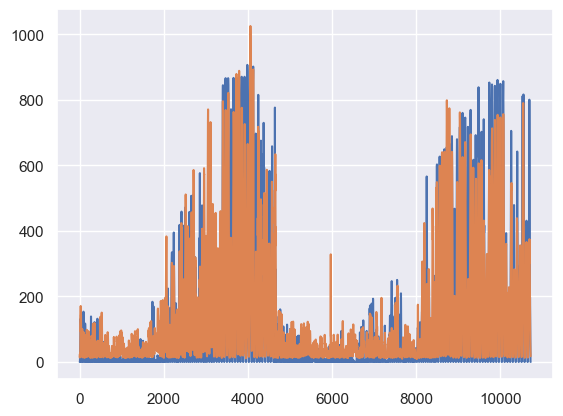

In [106]:
plt.plot(Y_Test_lstm)
plt.plot(prediction)
plt.show()

In [68]:
np.mean(Y_Test_lstm)

124.37527512946504

In [258]:
#Split Train, Validation, Test
X_Train,X_Test, Y_Train, Y_Test = train_test_split(X_Train_lags, Y_Train_sample.iloc[:,1],
                                                    test_size=0.2,
                                                    shuffle=False
                                                    )
X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_Train, Y_Train,
                                                    test_size=0.2,
                                                    shuffle=False
                                                    )

In [260]:
#MLP
model_NN = Sequential()
model_NN.add(Dense(X_Train.shape[1], input_shape=(X_Train.shape[1],), activation = 'relu')
        )
model_NN.add(Dense(256, activation = 'relu'))
model_NN.add(Dense(128, activation = 'relu'))
model_NN.add(Dense(64, activation = 'relu'))
model_NN.add(Dense(32, activation = 'relu'))
model_NN.add(Dropout(0.2))
model_NN.add(Dense(1, activation = 'linear'))

In [261]:
#Method to stop learning when there is no improvement
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, mode = "min", verbose=1,
                                                  restore_best_weights = True, start_from_epoch = 50)
model_NN.compile(optimizer='adam', loss='mean_squared_error')

In [262]:
#MLP Model training
history = model_NN.fit(X_Train, Y_Train, epochs=500, batch_size=128, validation_data=(X_Val, Y_Val), verbose=2,
                callbacks=[early_stopping], shuffle=False
                )

Epoch 1/500
390/390 - 3s - loss: 976159.9375 - val_loss: 546281.1250 - 3s/epoch - 8ms/step
Epoch 2/500
390/390 - 2s - loss: 528892.7500 - val_loss: 561778.3125 - 2s/epoch - 5ms/step
Epoch 3/500
390/390 - 2s - loss: 512742.6875 - val_loss: 589147.4375 - 2s/epoch - 4ms/step
Epoch 4/500
390/390 - 2s - loss: 506710.0000 - val_loss: 581429.2500 - 2s/epoch - 4ms/step
Epoch 5/500
390/390 - 2s - loss: 492097.9062 - val_loss: 548279.2500 - 2s/epoch - 4ms/step
Epoch 6/500
390/390 - 2s - loss: 491232.6250 - val_loss: 554390.1875 - 2s/epoch - 4ms/step
Epoch 7/500
390/390 - 2s - loss: 485941.4688 - val_loss: 548346.1250 - 2s/epoch - 4ms/step
Epoch 8/500
390/390 - 2s - loss: 485615.3750 - val_loss: 559739.0000 - 2s/epoch - 5ms/step
Epoch 9/500
390/390 - 2s - loss: 473485.5625 - val_loss: 551802.1250 - 2s/epoch - 4ms/step
Epoch 10/500
390/390 - 2s - loss: 480556.6562 - val_loss: 594251.8750 - 2s/epoch - 4ms/step
Epoch 11/500
390/390 - 2s - loss: 481400.4062 - val_loss: 585833.0625 - 2s/epoch - 4ms/st

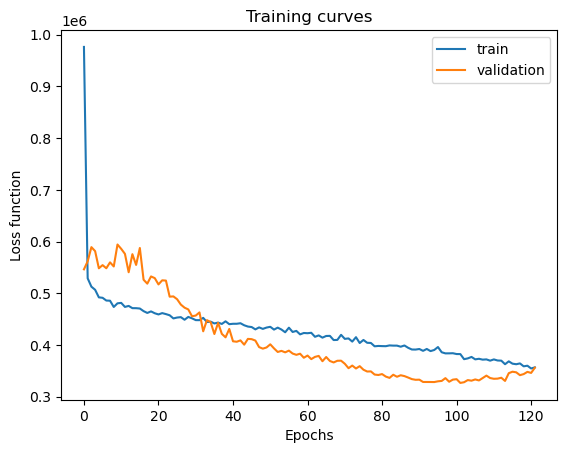

In [263]:
# plot history
plt.title("Training curves")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss function")
plt.legend()
plt.show()

487/487 [==============================] - 1s 2ms/step
Test MAE: 357.2876586158065


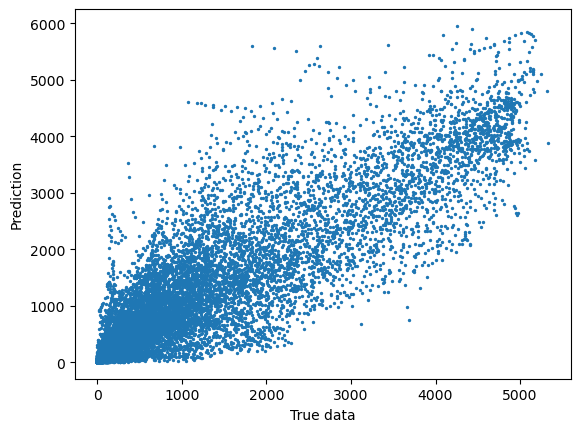

In [264]:
#Predict
prediction_NN =model_NN.predict(X_Test)
prediction_NN[prediction_NN<0] = 0

# calculate RMSE
mae = mean_absolute_error(Y_Test, prediction_NN)
print('Test MAE:', mae)

plt.scatter(Y_Test, prediction_NN, s=2)
plt.xlabel("True data")
plt.ylabel("Prediction")
plt.show()

# Clean version dataloader

In [31]:
LOCATION = "C"
n_lagged_features = 2
threshold = 0.9

X_Train_full,Y_Train_init,X_Test_full,selected_features = full_data_loader(location = LOCATION,
                                                        n_lagged_features=n_lagged_features,
                                                        threshold=threshold,
                                                        normalization = 'mean',
                                                        date_encoding=True,
                                                        verbose=True)
print(f"{len(selected_features)} features selected\n")
print(selected_features)

X_Train_init = X_Train_full[selected_features]

Reading datasets
Selecting training data
Encoding date information
Adding lag features
Normalizing with mean

Done

90 features selected

['air_density_2m_kgm3', 'air_density_2m_kgm3__r15', 'air_density_2m_kgm3__r30', 'ceiling_height_agl_m', 'ceiling_height_agl_m__r15', 'ceiling_height_agl_m__r30', 'clear_sky_energy_1h_J', 'clear_sky_energy_1h_J__r15', 'clear_sky_energy_1h_J__r30', 'cloud_base_agl_m', 'cloud_base_agl_m__r15', 'cloud_base_agl_m__r30', 'dew_or_rime_idx', 'dew_or_rime_idx__r15', 'dew_or_rime_idx__r30', 'diffuse_rad_W', 'diffuse_rad_W__r15', 'diffuse_rad_W__r30', 'direct_rad_W', 'direct_rad_W__r15', 'direct_rad_W__r30', 'effective_cloud_cover_p', 'effective_cloud_cover_p__r15', 'effective_cloud_cover_p__r30', 'fresh_snow_12h_cm', 'fresh_snow_12h_cm__r15', 'fresh_snow_12h_cm__r30', 'fresh_snow_1h_cm', 'fresh_snow_1h_cm__r15', 'fresh_snow_1h_cm__r30', 'is_day_idx', 'is_day_idx__r15', 'is_day_idx__r30', 'is_in_shadow_idx', 'is_in_shadow_idx__r15', 'is_in_shadow_idx__r30', 'ms

In [10]:
X_Train_init

,air_density_2m_kgm3,air_density_2m_kgm3__r15,air_density_2m_kgm3__r30,ceiling_height_agl_m,ceiling_height_agl_m__r15,ceiling_height_agl_m__r30,clear_sky_energy_1h_J,clear_sky_energy_1h_J__r15,clear_sky_energy_1h_J__r30,cloud_base_agl_m,...,sin_day__r30,sin_year,sin_year__r15,sin_year__r30,cos_year,cos_year__r15,cos_year__r30,forecast_interval,forecast_interval__r15,forecast_interval__r30
1,-0.337101,-0.341417,-0.346269,-0.949475,-0.948275,-0.946557,1.093915,1.093315,1.092609,-0.574817,...,1.025272,0.314104,0.314104,0.314104,-1.243268,-1.243268,-1.243268,-0.357496,-0.357455,-0.357428
2,-0.337101,-0.341417,-0.346269,-0.932739,-0.948275,-0.946557,1.070758,1.093315,1.092609,-0.552639,...,1.025272,0.314104,0.314104,0.314104,-1.243268,-1.243268,-1.243268,-0.357496,-0.357455,-0.357428
3,-0.337101,-0.341417,-0.346269,-0.915971,-0.931545,-0.946557,1.037989,1.070196,1.092609,-0.530419,...,1.025272,0.314104,0.314104,0.314104,-1.243268,-1.243268,-1.243268,-0.357496,-0.357455,-0.357428
4,-0.306511,-0.341417,-0.346269,-0.899235,-0.914783,-0.929837,0.995780,1.037482,1.069546,-0.508242,...,1.013158,0.314104,0.314104,0.314104,-1.243268,-1.243268,-1.243268,-0.357496,-0.357455,-0.357428
5,-0.337101,-0.310926,-0.346269,-0.882467,-0.898053,-0.913086,0.944351,0.995342,1.036912,-0.486022,...,0.993027,0.314104,0.314104,0.314104,-1.243268,-1.243268,-1.243268,-0.357496,-0.357455,-0.357428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42356,1.222890,1.183047,1.142815,-0.733522,-0.728694,-0.723404,-1.166402,-1.143445,-1.107202,-0.660629,...,-1.582006,0.339966,0.339966,0.339966,1.102027,1.102027,1.102027,3.649763,3.656298,3.662092
42357,1.222890,1.213537,1.173202,-0.723157,-0.732401,-0.727109,-1.174189,-1.163262,-1.138671,-0.654370,...,-1.694576,0.339966,0.339966,0.339966,1.102027,1.102027,1.102027,3.676840,3.683604,3.689624
42358,1.253480,1.213537,1.203593,-0.712793,-0.722040,-0.730814,-1.175200,-1.171036,-1.158439,-0.648070,...,-1.803569,0.339966,0.339966,0.339966,1.102027,1.102027,1.102027,3.703917,3.710909,3.717156
42359,1.253480,1.244028,1.203593,-0.702428,-0.711679,-0.720459,-1.175200,-1.172045,-1.166194,-0.641812,...,-1.908518,0.339966,0.339966,0.339966,1.102027,1.102027,1.102027,3.730994,3.738215,3.744688


In [11]:
#Split Train, Validation, Test
#Test_size = 0.4 if stack models, = 0.2 if not
X_Train,X_Test, Y_Train, Y_Test = train_test_split(X_Train_init, Y_Train_init,
                                                    test_size=0.4,
                                                    shuffle=True
                                                    )
X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_Train, Y_Train,
                                                    test_size=0.2,
                                                    shuffle=True
                                                    )

# LSTM

In [47]:
X_Train_LSTM = reshape_data_for_LSTM(X_Train,n_lagged_features)
X_Val_LSTM   = reshape_data_for_LSTM(X_Val,n_lagged_features)
X_Test_LSTM  = reshape_data_for_LSTM(X_Test,n_lagged_features)

(25725, 4, 35)
(6432, 4, 35)
(21439, 4, 35)


In [77]:
value_L2 = 1e-3

model_LSTM = Sequential()
model_LSTM.add(LSTM(X_Train_LSTM.shape[2]*n_lagged_features, activation='relu',return_sequences = True, 
                    input_shape=(n_lagged_features+1, X_Train_LSTM.shape[2]),
                    kernel_regularizer=l2(value_L2)
                    ))
model_LSTM.add(LSTM(units = 100,activation='relu',return_sequences = True, kernel_regularizer=l2(value_L2)))
model_LSTM.add(LSTM(units = 50, activation='relu',kernel_regularizer=l2(value_L2)))
model_LSTM.add(Dense(32, activation ='relu'))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(16, activation ='relu'))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(1, activation ='linear'))

opt = keras.optimizers.Adam(learning_rate=0.01)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, mode = "min", verbose=1,
                                                  restore_best_weights = False, start_from_epoch = 20)
model_LSTM.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 5, 140)            98560     
                                                                 
 lstm_17 (LSTM)              (None, 5, 100)            96400     
                                                                 
 lstm_18 (LSTM)              (None, 50)                30200     
                                                                 
 dense_190 (Dense)           (None, 32)                1632      
                                                                 
 dropout_75 (Dropout)        (None, 32)                0         
                                                                 
 dense_191 (Dense)           (None, 16)                528       
                                                                 
 dropout_76 (Dropout)        (None, 16)              

In [78]:
model_LSTM.compile(optimizer=opt, loss='mae')
history = model_LSTM.fit(x=X_Train_LSTM,
                    y=Y_Train,
                    batch_size = 256, 
                    steps_per_epoch=1, 
                    epochs=500, 
                    verbose=2,
                    validation_data = [X_Val_LSTM, Y_Val],
                    callbacks = [early_stopping] 
                    )

Epoch 1/500
1/1 - 7s - loss: 202.0550 - val_loss: 278.7647 - 7s/epoch - 7s/step
Epoch 2/500
1/1 - 1s - loss: 229.1552 - val_loss: 275.9503 - 849ms/epoch - 849ms/step
Epoch 3/500
1/1 - 1s - loss: 220.3008 - val_loss: 252.7608 - 850ms/epoch - 850ms/step
Epoch 4/500
1/1 - 1s - loss: 176.9719 - val_loss: 335.2373 - 895ms/epoch - 895ms/step
Epoch 5/500
1/1 - 1s - loss: 186.4741 - val_loss: 175.6743 - 897ms/epoch - 897ms/step
Epoch 6/500
1/1 - 1s - loss: 141.4531 - val_loss: 210.8101 - 889ms/epoch - 889ms/step
Epoch 7/500
1/1 - 1s - loss: 173.1281 - val_loss: 199.3045 - 915ms/epoch - 915ms/step
Epoch 8/500
1/1 - 1s - loss: 181.1181 - val_loss: 144.6791 - 1s/epoch - 1s/step
Epoch 9/500
1/1 - 1s - loss: 139.4550 - val_loss: 153.9754 - 1s/epoch - 1s/step
Epoch 10/500
1/1 - 1s - loss: 157.0509 - val_loss: 103.2899 - 1s/epoch - 1s/step
Epoch 11/500
1/1 - 1s - loss: 110.9686 - val_loss: 120.6713 - 1s/epoch - 1s/step
Epoch 12/500
1/1 - 1s - loss: 129.0033 - val_loss: 119.8805 - 1s/epoch - 1s/step
E

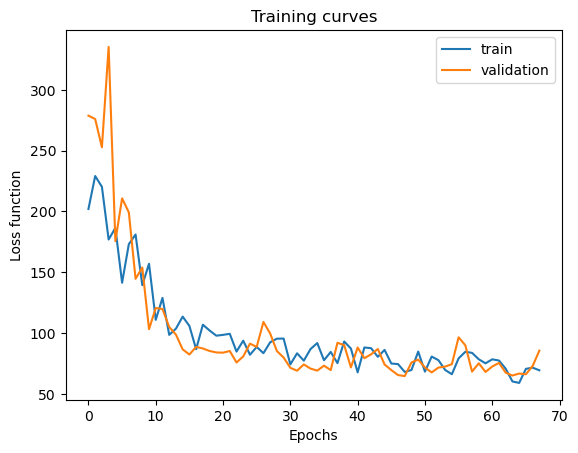

In [79]:
# plot history
plt.title("Training curves")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss function")
plt.legend()
plt.show()

335/335 [==============================] - 4s 9ms/step
mae =  72.85515014852092


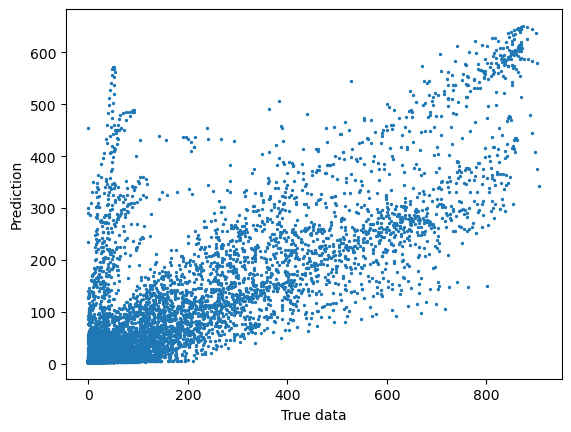

In [80]:
#Predict
prediction =model_LSTM.predict(X_Test_LSTM)
prediction[prediction<0] = 0

#Evaluate
mae = mean_absolute_error(Y_Test, prediction)
print("mae = ",mae)

plt.scatter(Y_Test, prediction, s=2)
plt.xlabel("True data")
plt.ylabel("Prediction")
plt.show()

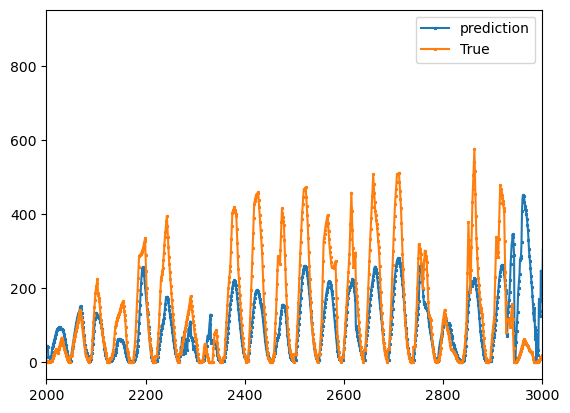

In [81]:
plt.plot(prediction,'-*', markersize=2, label='prediction')
plt.plot(Y_Test.reset_index(drop=True), '-*',markersize=2, label='True')
plt.legend()
plt.xlim([2000,3000])
plt.show()

# Classic NN

In [59]:
input_shape = X_Train_init.shape[1]
epochs = 500
batch_size = 256
fold = 0

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  patience = 20, 
                                                  mode = "min", 
                                                  verbose=1,
                                                  restore_best_weights = False, 
                                                  start_from_epoch = 20)

scores, histories =[], []
kFold=KFold(n_splits=5,shuffle=False)

for train_index, test_index in kFold.split(X_Train_init):
    X_train, X_test = X_Train_init.iloc[train_index], X_Train_init.iloc[test_index]
    y_train, y_test = Y_Train_init.iloc[train_index], Y_Train_init.iloc[test_index]

    # Create and compile the neural network model
    model_NN = create_NN_model(input_shape)
    model_NN.compile(optimizer='Adam', loss='mse')
    history = model_NN.fit(x=X_train,
                    y=y_train,
                    batch_size = batch_size, 
                    steps_per_epoch=1, 
                    epochs= epochs, 
                    verbose=0,
                    validation_data = [X_test, y_test],
                    callbacks = [early_stopping] 
                    )
    histories.append(history)
    # Evaluate the model on the test data
    prediction =model_NN.predict(X_test)
    prediction[prediction<0] = 0
    fold += 1
    mae = mean_absolute_error(y_test, prediction)
    print("Fold",fold,", mae = ",mae)
    scores.append(mae)

mae_average = np.mean( np.array(scores))
print("\nMAE averaged over folders = ",mae_average)
    

Epoch 63: early stopping
335/335 [==============================] - 1s 3ms/step
Fold 1 , mae =  83.03722347452523
Epoch 82: early stopping
335/335 [==============================] - 1s 3ms/step
Fold 2 , mae =  61.48547194328826
Epoch 84: early stopping
335/335 [==============================] - 1s 3ms/step
Fold 3 , mae =  59.31331810592291
Epoch 68: early stopping
335/335 [==============================] - 1s 3ms/step
Fold 4 , mae =  79.32458394807607
Epoch 77: early stopping
335/335 [==============================] - 1s 3ms/step
Fold 5 , mae =  53.44482755144122
MAE averaged over folders =  67.32108500465074


# LSTM,CNN in parallel + MLP to correct prediction

In [12]:
X_Train_LSTM = reshape_data_for_LSTM(X_Train,n_lagged_features)
X_Val_LSTM   = reshape_data_for_LSTM(X_Val,n_lagged_features)
X_Test_LSTM  = reshape_data_for_LSTM(X_Test,n_lagged_features)

(20332, 3, 36)
(5084, 3, 36)
(16944, 3, 36)


In [18]:
# Network implementation

#Parameters
input_shape_CNN = (n_lagged_features+1, X_Train_LSTM.shape[2])
input_shape_LSTM = (n_lagged_features+1, X_Train_LSTM.shape[2])
value_L2_LSTM = 1e-4

#CNN part
inputs1 = Input(shape = input_shape_CNN)
x1 = Conv1D(filters = 32, kernel_size=n_lagged_features+1,strides=1,padding='same',
            activation='relu',use_bias=True, input_shape=input_shape_CNN)(inputs1)
x1 = MaxPooling1D(pool_size = 2, strides = None, padding = 'valid')(x1)
x1 = Conv1D(filters = 16,kernel_size = 2,padding = 'same', activation='relu')(x1)
#x1 = MaxPooling1D(pool_size = 2, strides = None, padding = 'valid')(x1)
outputs1 = Flatten()(x1) # Flattening to be able to concatenate

#LSTM part
inputs2 = Input(shape = input_shape_LSTM)
x2 = LSTM(units=X_Train_LSTM.shape[2]*n_lagged_features, activation='relu',return_sequences = True, 
                    input_shape=(n_lagged_features+1, X_Train_LSTM.shape[2]),
                    kernel_regularizer=l2(value_L2_LSTM))(inputs2)
x2 = LSTM(units = 75,activation='relu',return_sequences = True, kernel_regularizer=l2(value_L2_LSTM))(x2)
x2 = LSTM(units = 50, activation='relu',kernel_regularizer=l2(value_L2_LSTM))(x2)
outputs2 = Flatten()(x2)

#Final network
x = concatenate([outputs1, outputs2])
x = Dense(32, activation = 'relu', use_bias = True)(x)
x = Dense(16, activation = 'relu', use_bias = True)(x)
x = Dropout(0.2)(x)
outputs = Dense(1,activation = 'linear')(x) 

In [19]:
model_LSTM_CNN = tf.keras.Model(inputs=[inputs1,inputs2], outputs=outputs, name ="CNN_LSTM")
model_LSTM_CNN.summary()

Model: "CNN_LSTM"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 3, 36)]              0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 3, 36)]              0         []                            
                                                                                                  
 conv1d_10 (Conv1D)          (None, 3, 32)                3488      ['input_6[0][0]']             
                                                                                                  
 lstm (LSTM)                 (None, 3, 72)                31392     ['input_7[0][0]']             
                                                                                           

In [20]:
#Parameters
input_shape_CNN = (n_lagged_features+1, X_Train_LSTM.shape[2])
input_shape_LSTM = (n_lagged_features+1, X_Train_LSTM.shape[2])
SEED = 42

#Hyperparameters
nbr_filter_conv1_list = [32,16,8]
nbr_filter_conv2_list = [16,8,4]
kernel_size2_list = [6,3]
LSTM_unit2_list = [150,100,50]
LSTM_unit3_list = [100,50,25]
L2_regularization_list = [1e-4,1e-3,1e-2]
nbr_dense_unit1 = [32,16,8]
nbr_dense_unit2 = [16,8,4]

paramaters = dict(filters1 = nbr_filter_conv1_list, 
                  filtets2 = nbr_filter_conv2_list, 
                  kernel2 = kernel_size2_list, 
                  Unit2LSTM = LSTM_unit2_list,
                  Unit3LSTM = LSTM_unit3_list, 
                  L2_vals = L2_regularization_list, 
                  Unit1 = nbr_dense_unit1, 
                  Unit2 = nbr_dense_unit2)

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  patience = 20, 
                                                  mode = "min", 
                                                  verbose=1,
                                                  restore_best_weights = False, 
                                                  start_from_epoch = 20)

model_LSTM_CNN.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='mae')
history = model_LSTM_CNN.fit(x=[X_Train_LSTM,X_Train_LSTM],
                    y=Y_Train,
                    batch_size = 256, 
                    steps_per_epoch=1, 
                    epochs=500, 
                    verbose=2,
                    validation_data = ([X_Val_LSTM,X_Val_LSTM], Y_Val),
                    callbacks = [early_stopping] 
                    )

Epoch 1/500
1/1 - 7s - loss: 200.8102 - val_loss: 183.0855 - 7s/epoch - 7s/step
Epoch 2/500
1/1 - 0s - loss: 199.4804 - val_loss: 183.0567 - 228ms/epoch - 228ms/step
Epoch 3/500
1/1 - 0s - loss: 192.4377 - val_loss: 183.0273 - 225ms/epoch - 225ms/step
Epoch 4/500
1/1 - 0s - loss: 169.8951 - val_loss: 182.9971 - 234ms/epoch - 234ms/step
Epoch 5/500
1/1 - 0s - loss: 191.6581 - val_loss: 182.9655 - 233ms/epoch - 233ms/step
Epoch 6/500
1/1 - 0s - loss: 190.3784 - val_loss: 182.9324 - 233ms/epoch - 233ms/step
Epoch 7/500
1/1 - 0s - loss: 189.9347 - val_loss: 182.8977 - 231ms/epoch - 231ms/step
Epoch 8/500
1/1 - 0s - loss: 162.6785 - val_loss: 182.8612 - 231ms/epoch - 231ms/step
Epoch 9/500
1/1 - 0s - loss: 177.2758 - val_loss: 182.8224 - 239ms/epoch - 239ms/step
Epoch 10/500
1/1 - 0s - loss: 192.5794 - val_loss: 182.7810 - 239ms/epoch - 239ms/step
Epoch 11/500
1/1 - 0s - loss: 185.8552 - val_loss: 182.7365 - 239ms/epoch - 239ms/step
Epoch 12/500
1/1 - 0s - loss: 204.8370 - val_loss: 182.688

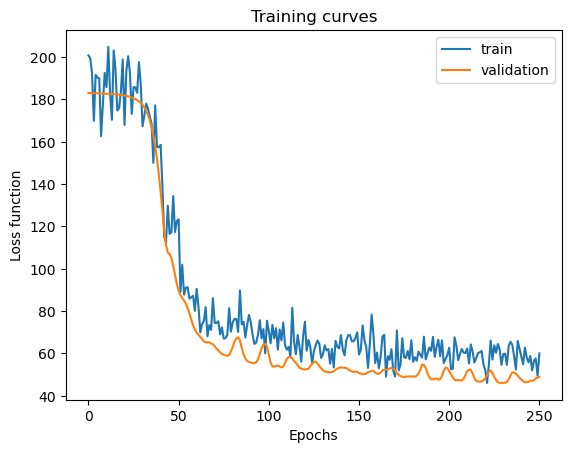

In [22]:
# plot history
plt.title("Training curves")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss function")
plt.legend()
plt.show()

530/530 [==============================] - 3s 5ms/step
mae =  50.51473121870749


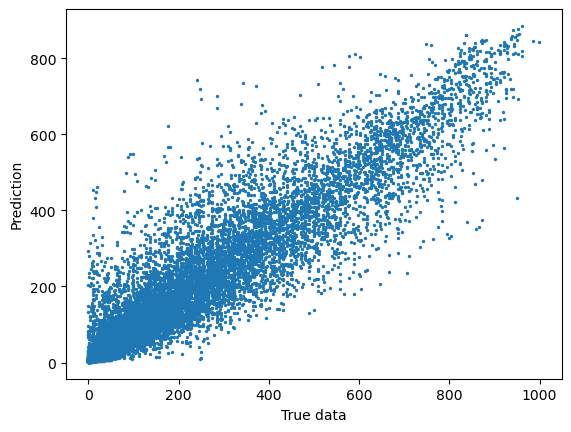

In [23]:
#Predict
prediction_LSTM_CNN =model_LSTM_CNN.predict([X_Test_LSTM,X_Test_LSTM])
prediction_LSTM_CNN[prediction_LSTM_CNN<0] = 0

#Evaluate
mae = mean_absolute_error(Y_Test, prediction_LSTM_CNN)
print("mae = ",mae)

plt.scatter(Y_Test, prediction_LSTM_CNN, s=2)
plt.xlabel("True data")
plt.ylabel("Prediction")
plt.show()

## Correct previous prediction with neural network (MLP)

In [24]:
#Remove lagged features
X_test_wo_lagged = remove_lagged_features(X_Test)

#Add normalized prediction to X_test
scaler = StandardScaler()
prediction_noramlized = scaler.fit_transform(prediction_LSTM_CNN)
prediction_pd = pd.DataFrame(data=prediction_noramlized, columns=['prediction'])

#X_Test + Prediction become X_Train
X_Train_second = pd.concat((X_test_wo_lagged.reset_index(drop=True), prediction_pd), axis=1)
Y_Train_second = Y_Test

In [25]:
X_Train_second

,air_density_2m_kgm3,ceiling_height_agl_m,clear_sky_energy_1h_J,cloud_base_agl_m,effective_cloud_cover_p,fresh_snow_12h_cm,fresh_snow_1h_cm,fresh_snow_24h_cm,fresh_snow_3h_cm,fresh_snow_6h_cm,...,visibility_m,wind_speed_10m_ms,wind_speed_u_10m_ms,wind_speed_v_10m_ms,wind_speed_w_1000hPa_ms,sin_day,sin_year,cos_year,forecast_interval,prediction
0,-0.000631,0.536453,0.291149,-0.770719,0.252523,-0.088361,-0.046966,-0.100261,-0.064252,-0.083161,...,-0.073585,-0.421653,0.367082,-0.783120,-0.029186,-0.780687,1.222534,0.170835,-0.357496,0.242808
1,-0.061810,-0.948397,-0.231579,-0.735394,0.958362,-0.088361,-0.046966,-0.100261,-0.064252,-0.083161,...,-1.567246,1.227588,1.308448,1.178630,-0.029186,0.062160,-0.441640,1.249186,-0.357496,-0.682509
2,-0.000631,-0.885890,-1.074801,-0.490558,0.989544,-0.088361,-0.046966,-0.100261,-0.064252,-0.083161,...,-1.713923,2.571414,2.167956,1.643255,-0.029186,1.015257,-2.117758,-0.110759,-0.357496,-0.880719
3,1.069950,1.458110,-0.500680,-0.870560,0.221341,-0.088361,-0.046966,-0.100261,-0.064252,-0.083161,...,-0.576193,1.288671,1.635880,-0.731495,-0.029186,0.631083,-1.394888,1.014493,-0.357496,-0.654262
4,-1.897091,1.139713,2.117755,0.393858,-0.280400,-0.088361,-0.046966,-0.100261,-0.064252,-0.083161,...,1.331910,1.105422,-1.474722,1.694880,-0.029186,1.015257,1.064740,0.533877,-0.357496,2.336626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16939,0.397014,0.502284,-0.928007,1.276889,-1.794129,-0.088361,-0.046966,-0.100261,-0.064252,-0.083161,...,0.654165,-0.910317,-0.533356,0.455880,-0.029186,-0.654388,-0.067666,-1.348670,-0.357496,-0.244780
16940,-1.315917,-1.152907,0.942115,-0.129458,-1.805467,-0.088361,-0.046966,-0.100261,-0.064252,-0.083161,...,1.089049,-0.788151,-0.860787,-0.524995,-0.029186,0.884222,0.365600,-1.222460,-0.357496,1.360066
16941,1.222890,-0.592439,-0.250538,-0.378830,1.029230,-0.088361,-0.046966,-0.100261,-0.064252,-0.083161,...,0.616343,0.005928,0.817300,0.146130,-0.029186,0.273090,-0.758550,1.224622,-0.357496,-0.639627
16942,0.947599,2.417232,-0.669102,1.508032,0.201498,-0.088361,-0.046966,-0.100261,-0.064252,-0.083161,...,0.331600,-0.177321,-0.287782,1.127005,-0.029186,-0.405580,-0.039422,-1.343552,-0.357496,-0.213778


In [26]:
#Split Train, Validation, Test
X_Train,X_Test, Y_Train, Y_Test = train_test_split(X_Train_second, Y_Train_second,
                                                    test_size=0.2,
                                                    shuffle=True
                                                    )
X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_Train, Y_Train,
                                                    test_size=0.2,
                                                    shuffle=True
                                                    )

print("Nbr of samples for training = ", X_Train.shape[0])

Nbr of samples for training =  10844


In [27]:
input_shape = X_Train.shape[1]
epochs = 500
batch_size = 128
fold = 0

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  patience = 20, 
                                                  mode = "min", 
                                                  verbose=1,
                                                  restore_best_weights = False, 
                                                  start_from_epoch = 20)

scores, histories =[], []
kFold=KFold(n_splits=5,shuffle=True)

for train_index, test_index in kFold.split(X_Train):
    X_train, X_test = X_Train.iloc[train_index], X_Train.iloc[test_index]
    y_train, y_test = Y_Train.iloc[train_index], Y_Train.iloc[test_index]

    # Create and compile the neural network model
    model_NN_stack = create_NN_model(input_shape)
    model_NN_stack.compile(optimizer='Adam', loss='mse')
    history = model_NN_stack.fit(x=X_train,
                    y=y_train,
                    batch_size = batch_size, 
                    steps_per_epoch=1, 
                    epochs= epochs, 
                    verbose=0,
                    validation_data = [X_test, y_test],
                    callbacks = [early_stopping] 
                    )
    histories.append(history)
    # Evaluate the model on the test data
    prediction =model_NN_stack.predict(X_test)
    prediction[prediction<0] = 0
    fold += 1
    mae = mean_absolute_error(y_test, prediction)
    print("Fold",fold,", mae = ",mae)
    scores.append(mae)

mae_average = np.mean( np.array(scores))
print("\nMAE averaged over folders = ",mae_average)

Epoch 179: early stopping
68/68 [==============================] - 0s 3ms/step
Fold 1 , mae =  54.189840942005745
Epoch 351: early stopping
68/68 [==============================] - 0s 2ms/step
Fold 2 , mae =  49.49628799755847
Epoch 473: early stopping
68/68 [==============================] - 0s 2ms/step
Fold 3 , mae =  48.00835206604357
Epoch 141: early stopping
68/68 [==============================] - 0s 2ms/step
Fold 4 , mae =  55.56023724838313
Epoch 232: early stopping
68/68 [==============================] - 0s 3ms/step
Fold 5 , mae =  59.26093356937108

MAE averaged over folders =  53.303130364672406


  1/106 [..............................] - ETA: 5s

106/106 [==============================] - 0s 4ms/step
mae =  59.7637538687852


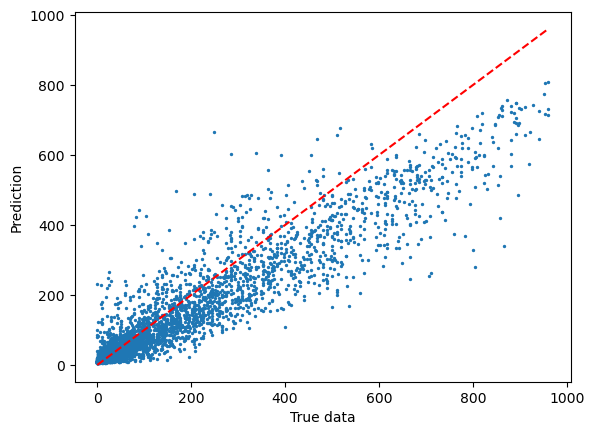

In [28]:
#Predict
prediction_NN_stack = model_NN_stack.predict(X_Test)
prediction_NN_stack[prediction_NN_stack<0] = 0

#Evaluate
mae = mean_absolute_error(Y_Test, prediction_NN_stack)
print("mae = ",mae)

X = np.linspace(0,max(Y_Test.max(), np.max(prediction_NN_stack)))
plt.scatter(Y_Test, prediction_NN_stack, s=2)
plt.plot(X,X, '--',c='r')
plt.xlabel("True data")
plt.ylabel("Prediction")
plt.show()

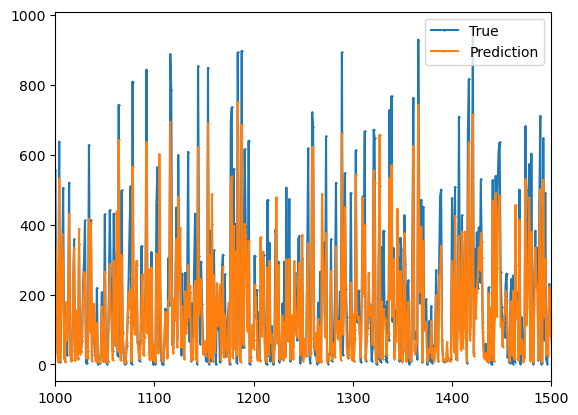

In [29]:
#Plot shuffle 
plt.plot(Y_Test.reset_index(drop=True),'-*', markersize=1, label='True')
plt.plot(prediction_NN_stack,'-*', markersize=1, label='Prediction')
plt.xlim([1000,1500])
plt.legend()
plt.show()

# Hyperparameters search

In [125]:
def build_model_LSTM_CNN(hp):
    #Parameters
    input_shape_CNN = (n_lagged_features+1, X_Train_LSTM.shape[2])
    input_shape_LSTM = (n_lagged_features+1, X_Train_LSTM.shape[2])

    #CNN part
    inputs1 = Input(shape = input_shape_CNN)
    x1 = Conv1D(filters = 32, kernel_size=n_lagged_features+1,strides=1,padding='same',
                activation='relu',use_bias=True, input_shape=input_shape_CNN)(inputs1)
    x1 = MaxPooling1D(pool_size = 2, strides = None, padding = 'valid')(x1)
    x1 = Conv1D(filters = 16,kernel_size = 6,padding = 'same', activation='relu')(x1)
    x1 = MaxPooling1D(pool_size = 2, strides = None, padding = 'valid')(x1)
    outputs1 = Flatten()(x1) # Flattening to be able to concatenate
    """ 
    inputs1 = Input(shape = input_shape_CNN)
    x1 = Conv1D(filters = hp.Int("Nbr_filters1 ", min_value = 8, max_value=32, step=4), 
                kernel_size=n_lagged_features+1,
                padding='same',
                activation='relu',
                input_shape=input_shape_CNN)(inputs1)
    x1 = MaxPooling1D(pool_size =  2)#hp.Int("Pool_size1 ", min_value = 2, max_value=6, step=2))(x1)
    x1 = Conv1D(filters = hp.Int("Nbr_filters2 ", min_value = 4, max_value=16, step=4),
                kernel_size =  hp.Int("Kernel_size2 ", min_value = 32, max_value=128, step=4),
                padding = 'same',
                activation='relu')(x1)
    x1 = MaxPooling1D(pool_size=2)#hp.Int("Pool_size2 ", min_value = 2, max_value=6, step=2))(x1)
    outputs1 = Flatten()(x1) # Flattening to be able to concatenate      
    """

    #LSTM part
    value_L2 = hp.Float("Value L2",min_value = 1e-4, max_value = 1e-2, step=10, sampling='log')
    inputs2 = Input(shape = input_shape_LSTM)
    x2 = LSTM(units=X_Train_LSTM.shape[2]*n_lagged_features,
              activation='relu',
              return_sequences = True, 
              input_shape=(n_lagged_features+1, X_Train_LSTM.shape[2]),
              kernel_regularizer=l2(value_L2))(inputs2)
    x2 = LSTM(units = hp.Int("Unit_LSTM2", min_value = 50, max_value = 100, step = 25),
              activation='relu',
              return_sequences = True,
              kernel_regularizer=l2(value_L2))(x2)
    x2 = LSTM(units = hp.Int("Unit_LSTM3", min_value = 20, max_value = 50, step =10),
              activation='relu',
              kernel_regularizer=l2(value_L2))(x2)
    outputs2 = Flatten()(x2)

    #Final network
    x = concatenate([outputs1, outputs2])
    x = Dense(hp.Int("Unit_Dense1", min_value = 16, max_value = 64, step = 4),
              activation = 'relu')(x)
    x = Dense(hp.Int("Unit_Dense1", min_value = 4, max_value = 16, step = 4),
              activation = 'relu')(x)
    x = Dropout(hp.Float("Value L2",min_value = 0.1, max_value = 0.3, step=0.1))(x)
    outputs = Dense(1,activation = 'linear')(x)

    model_LSTM_CNN = tf.keras.Model(inputs=[inputs1,inputs2], outputs=outputs, name ="CNN_LSTM")
    model_LSTM_CNN.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='mae')
    
    return model_LSTM_CNN



def build_model_NN(hp):

    input_shape = X_Train.shape[1]

    #Hyperparemeters
    value_L2 = hp.Float("Value-L2",min_value = 1e-4, max_value = 1e-2, step=10, sampling='log')
    dropout = hp.Float("Dropout",min_value = 0.1, max_value = 0.3, step=0.1)
    unit1_3 = hp.Int("Nbr_unit13 ", min_value=128, max_value=256, step = 128)
    unit2 = hp.Int("Nbr_unit2 ", min_value=256, max_value=512, step = 256)
    unit4 = hp.Int("Nbr_unit2 ", min_value=128, max_value=256, step = 128)
    unit5 = hp.Int("Nbr_unit4 ", min_value=32, max_value=64, step = 32)

    model_NN = Sequential()
    model_NN.add(Input(shape=(input_shape)))
    model_NN.add(Dense(input_shape,
                activation='relu',
                kernel_regularizer=tf.keras.regularizers.l2(value_L2)))   
    model_NN.add(Dense(unit1_3,
                       activation='relu',
                       kernel_regularizer=tf.keras.regularizers.l2(value_L2)))            
    model_NN.add(Dense(unit2,
                       activation='relu'))           
    model_NN.add(Dropout(dropout))                      
    model_NN.add(Dense(unit1_3,
                       activation='relu'))            
    model_NN.add(Dense(unit4,
                       ctivation='relu',
                       kernel_regularizer=tf.keras.regularizers.l2(value_L2)))           
    model_NN.add(Dropout(dropout))                           
    model_NN.add(Dense(unit5,
                       activation='relu'))            
    model_NN.add(Dropout(dropout))                           
    model_NN.add(Dense(16,
                       activation='relu',
                       kernel_regularizer=tf.keras.regularizers.l2(value_L2)))            
    model_NN.add(Dense(1, activation='linear')) 

    model_NN.compile(optimizer='Adam', loss='mse')

    return model_NN

In [126]:
#Split Train, Validation, Test
#Test_size = 0.4 if stack models, = 0.2 if not
X_Train,X_Test, Y_Train, Y_Test = train_test_split(X_Train_init, Y_Train_init,
                                                    test_size=0.4,
                                                    shuffle=True
                                                    )
X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_Train, Y_Train,
                                                    test_size=0.2,
                                                    shuffle=True
                                                    )

X_Train_LSTM = reshape_data_for_LSTM(X_Train,n_lagged_features)
X_Val_LSTM   = reshape_data_for_LSTM(X_Val,n_lagged_features)
X_Test_LSTM  = reshape_data_for_LSTM(X_Test,n_lagged_features)

(20332, 7, 36)
(5084, 7, 36)
(16944, 7, 36)


In [127]:
tuner_LSTM_CNN = keras_tuner.Hyperband(
    hypermodel=build_model_LSTM_CNN,
    objective="val_loss",
    max_epochs=500,
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  patience = 20, 
                                                  mode = "min", 
                                                  verbose=1,
                                                  restore_best_weights = False, 
                                                  start_from_epoch = 20)

Reloading Tuner from .\untitled_project\tuner0.json


In [128]:
tuner_LSTM_CNN.search([X_Train_LSTM,X_Train_LSTM],
            Y_Train,
            steps_per_epoch=500,
            validation_data=([X_Val_LSTM,X_Val_LSTM], Y_Val),
            validation_steps=100,
            callbacks=[early_stopping]
            )

Trial 61 Complete [00h 01m 11s]
val_loss: 43.757694244384766

Best val_loss So Far: 41.81144714355469
Total elapsed time: 01h 21m 42s

Search: Running Trial #62

Value             |Best Value So Far |Hyperparameter
8                 |12                |Nbr_filters1 
2                 |4                 |Pool_size1 
12                |8                 |Nbr_filters2 
120               |120               |Kernel_size2 
2                 |6                 |Pool_size2 
0.01              |0.001             |Value L2
50                |75                |Unit_LSTM2
48                |37                |Unit_LSTM3
36                |20                |Unit_Dense1
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
5                 |5                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3
200/500 [===========>..................] - ETA: 13s - loss: 77.7903

KeyboardInterrupt: 

In [ ]:
best_model_CNN_LSTM = tuner_LSTM_CNN.get_best_models()[0]

#Predict
prediction_LSTM_CNN =best_model_CNN_LSTM.predict([X_Test_LSTM,X_Test_LSTM])
prediction_LSTM_CNN[prediction_LSTM_CNN<0] = 0

#Evaluate
mae = mean_absolute_error(Y_Test, prediction_LSTM_CNN)
print("mae = ",mae)

plt.scatter(Y_Test, prediction_LSTM_CNN, s=2)
plt.xlabel("True data")
plt.ylabel("Prediction")
plt.show()

In [ ]:
#Remove lagged features
X_test_wo_lagged = remove_lagged_features(X_Test)

#Add normalized prediction to X_test
scaler = StandardScaler()
prediction_noramlized = scaler.fit_transform(prediction_LSTM_CNN)
prediction_pd = pd.DataFrame(data=prediction_noramlized, columns=['prediction'])

#X_Test + Prediction become X_Train
X_Train_second = pd.concat((X_test_wo_lagged.reset_index(drop=True), prediction_pd), axis=1)
Y_Train_second = Y_Test

#Split Train, Validation, Test
X_Train,X_Test, Y_Train, Y_Test = train_test_split(X_Train_second, Y_Train_second,
                                                    test_size=0.2,
                                                    shuffle=True
                                                    )
X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_Train, Y_Train,
                                                    test_size=0.2,
                                                    shuffle=True
                                                    )

print("Nbr of samples for training = ", X_Train.shape[0])

In [ ]:
input_shape = X_Train.shape[1]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  patience = 20, 
                                                  mode = "min", 
                                                  verbose=1,
                                                  restore_best_weights = False, 
                                                  start_from_epoch = 20)

tuner_NN = keras_tuner.Hyperband(
    hypermodel=build_model_NN
    objective="val_loss",
    max_epochs=500,
)

In [ ]:
tuner_NN.search(X_Train,
            Y_Train,
            steps_per_epoch=500,
            validation_data=(X_Val, Y_Val),
            validation_steps=100,
            callbacks=[early_stopping]
            )

In [ ]:
#Predict

best_model_NN = tuner_NN.get_best_models()[0]

prediction_NN = best_model_NN.predict(X_Test)
prediction_NN[prediction_NN<0] = 0

#Evaluate
mae = mean_absolute_error(Y_Test, prediction_NN)
print("mae = ",mae)

X = np.linspace(0,max(Y_Test.max(), np.max(prediction_NN)))
plt.scatter(Y_Test, prediction_NN, s=2)
plt.plot(X,X, '--',c='r')
plt.xlabel("True data")
plt.ylabel("Prediction")
plt.show()

# Separate obs and forecast dataset

In [236]:
LOCATION = "B"
n_lagged_features = 3
threshold = 0.9

X_Train_obs, X_Train_est, Y_Train_obs_init, Y_Train_est_init,X_Test_obs, X_Test_est, selected_features = full_data_loader_separate(location = LOCATION,
                                                        n_lagged_features=n_lagged_features,
                                                        threshold=threshold,
                                                        normalization = 'mean',
                                                        date_encoding=True,
                                                        verbose=True)

#Check shapes
print(X_Train_obs.shape[0] == Y_Train_obs_init.shape[0])
print(X_Train_est.shape[0] == Y_Train_est_init.shape[0])
print(X_Train_obs.shape[1] == X_Train_est.shape[1])

#Keep selected featues
X_Train_obs_init, X_Train_est_init,X_Test_obs_init, X_Test_est_init = X_Train_obs[selected_features],X_Train_est[selected_features],X_Test_obs[selected_features], X_Test_est[selected_features]

print(" Nbr samples of observed data = ", X_Train_obs.shape[0],'\n',
      "Nbr samples of estimated data = ", X_Train_est.shape[0],'\n',
      "Nbr of features = ",X_Train_obs.shape[1]
      )

Reading datasets
Selecting training data
Encoding date information
Adding lag features
Normalizing with mean

Done

True
True
True
 Nbr samples of observed data =  47548 
 Nbr samples of estimated data =  6044 
 Nbr of features =  193


In [237]:
#Split Train, Validation, Test
#Test_size = 0.4 if stack models, = 0.2 if not
X_Train_,X_Test, Y_Train_, Y_Test = train_test_split(X_Train_obs_init, Y_Train_obs_init,
                                                    test_size=0.2,
                                                    shuffle=True
                                                    )
X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_Train_, Y_Train_,
                                                    test_size=0.2,
                                                    shuffle=True
                                                    )

## LSTM as first model

In [238]:
#Reshape data for LSTM
X_Train_LSTM = reshape_data_for_LSTM(X_Train,n_lagged_features)
X_Val_LSTM   = reshape_data_for_LSTM(X_Val,n_lagged_features)
X_Test_LSTM  = reshape_data_for_LSTM(X_Test,n_lagged_features)

# Network implementation
#Parameters
input_shape_CNN = (n_lagged_features+1, X_Train_LSTM.shape[2])
input_shape_LSTM = (n_lagged_features+1, X_Train_LSTM.shape[2])
value_L2_LSTM = 1e-4

#CNN part
inputs1 = Input(shape = input_shape_CNN)
x1 = Conv1D(filters = 32, kernel_size=n_lagged_features+1,strides=1,padding='same',
            activation='relu',use_bias=True, input_shape=input_shape_CNN)(inputs1)
x1 = MaxPooling1D(pool_size = 2, strides = None, padding = 'valid')(x1)
x1 = Conv1D(filters = 16,kernel_size = 2,padding = 'same', activation='relu')(x1)
#x1 = MaxPooling1D(pool_size = 2, strides = None, padding = 'valid')(x1)
outputs1 = Flatten()(x1) # Flattening to be able to concatenate

#LSTM part
inputs2 = Input(shape = input_shape_LSTM)
x2 = LSTM(units=X_Train_LSTM.shape[2]*n_lagged_features, activation='relu',return_sequences = True, 
                    input_shape=(n_lagged_features+1, X_Train_LSTM.shape[2]),
                    kernel_regularizer=l2(value_L2_LSTM))(inputs2)
x2 = LSTM(units = 75,activation='relu',return_sequences = True, kernel_regularizer=l2(value_L2_LSTM))(x2)
x2 = LSTM(units = 50, activation='relu',kernel_regularizer=l2(value_L2_LSTM))(x2)
outputs2 = Flatten()(x2)

#Final network
x = concatenate([outputs1, outputs2])
x = Dense(32, activation = 'relu', use_bias = True)(x)
x = Dense(16, activation = 'relu', use_bias = True)(x)
x = Dropout(0.2)(x)
outputs = Dense(1,activation = 'linear')(x) 

model_LSTM_CNN = tf.keras.Model(inputs=[inputs1,inputs2], outputs=outputs, name ="CNN_LSTM")
model_LSTM_CNN.summary()

(30430, 4, 24)
(7608, 4, 24)
(9510, 4, 24)
Model: "CNN_LSTM"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_39 (InputLayer)       [(None, 4, 24)]              0         []                            
                                                                                                  
 input_40 (InputLayer)       [(None, 4, 24)]              0         []                            
                                                                                                  
 conv1d_32 (Conv1D)          (None, 4, 32)                3104      ['input_39[0][0]']            
                                                                                                  
 lstm_33 (LSTM)              (None, 4, 72)                27936     ['input_40[0][0]']            
                                                

In [239]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  patience = 20, 
                                                  mode = "min", 
                                                  verbose=1,
                                                  restore_best_weights = False, 
                                                  start_from_epoch = 20)

model_LSTM_CNN.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='mae')
history = model_LSTM_CNN.fit(x=[X_Train_LSTM,X_Train_LSTM],
                    y=Y_Train,
                    batch_size = 256, 
                    steps_per_epoch=1, 
                    epochs=500, 
                    verbose=2,
                    validation_data = ([X_Val_LSTM,X_Val_LSTM], Y_Val),
                    callbacks = [early_stopping] 
                    )

Epoch 1/500
1/1 - 6s - loss: 219.4063 - val_loss: 216.4734 - 6s/epoch - 6s/step
Epoch 2/500
1/1 - 1s - loss: 210.9003 - val_loss: 216.4130 - 946ms/epoch - 946ms/step
Epoch 3/500
1/1 - 1s - loss: 243.7607 - val_loss: 216.3503 - 944ms/epoch - 944ms/step
Epoch 4/500
1/1 - 1s - loss: 214.8406 - val_loss: 216.2847 - 956ms/epoch - 956ms/step
Epoch 5/500
1/1 - 1s - loss: 216.0694 - val_loss: 216.2154 - 939ms/epoch - 939ms/step
Epoch 6/500
1/1 - 1s - loss: 226.0709 - val_loss: 216.1418 - 916ms/epoch - 916ms/step
Epoch 7/500
1/1 - 1s - loss: 223.6401 - val_loss: 216.0630 - 926ms/epoch - 926ms/step
Epoch 8/500
1/1 - 1s - loss: 211.3945 - val_loss: 215.9782 - 913ms/epoch - 913ms/step
Epoch 9/500
1/1 - 1s - loss: 195.6316 - val_loss: 215.8869 - 918ms/epoch - 918ms/step
Epoch 10/500
1/1 - 1s - loss: 167.3819 - val_loss: 215.7884 - 922ms/epoch - 922ms/step
Epoch 11/500
1/1 - 1s - loss: 215.6069 - val_loss: 215.6811 - 914ms/epoch - 914ms/step
Epoch 12/500
1/1 - 1s - loss: 187.4441 - val_loss: 215.563

298/298 [==============================] - 2s 6ms/step
mae =  56.330914410088184


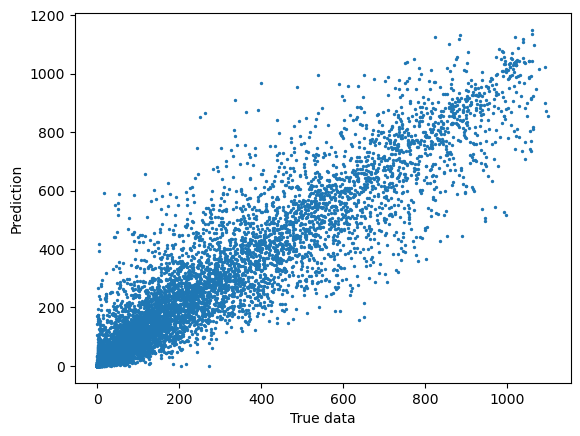

In [240]:
#Predict, not useful just to see 
prediction_LSTM_CNN =model_LSTM_CNN.predict([X_Test_LSTM,X_Test_LSTM])
prediction_LSTM_CNN[prediction_LSTM_CNN<0] = 0

#Evaluate
mae = mean_absolute_error(Y_Test, prediction_LSTM_CNN)
print("mae = ",mae)

plt.scatter(Y_Test, prediction_LSTM_CNN, s=2)
plt.xlabel("True data")
plt.ylabel("Prediction")
plt.show()

In [241]:
#Split Train, Validation, Test estimated data
X_Train_est_,X_Test_est, Y_Train_est_, Y_Test_est = train_test_split(X_Train_est_init, Y_Train_est_init,
                                                    test_size=0.2,
                                                    shuffle=True
                                                    )
X_Train_est, X_Val_est, Y_Train_est, Y_Val_est = train_test_split(X_Train_est_, Y_Train_est_,
                                                    test_size=0.2,
                                                    shuffle=True
                                                    )

(3868, 4, 24)
(967, 4, 24)
(1209, 4, 24)
38/38 [==============================] - 0s 5ms/step
mae =  113.26483646183506


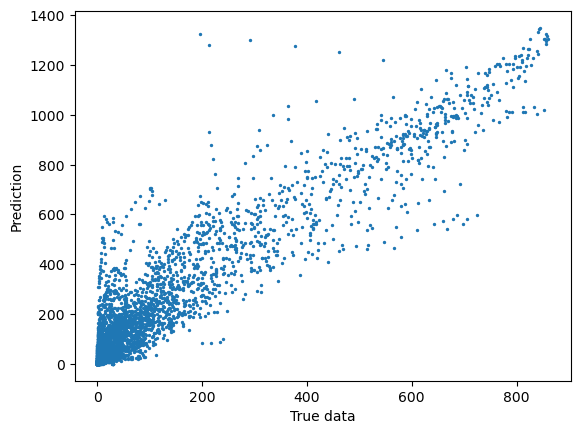

In [242]:
#Reshape data for LSTM
X_Train_LSTM_est = reshape_data_for_LSTM(X_Train_est,n_lagged_features)
X_Val_LSTM_est = reshape_data_for_LSTM(X_Val_est,n_lagged_features)
X_Test_LSTM_est = reshape_data_for_LSTM(X_Test_est,n_lagged_features)

#Predict
prediction_LSTM_CNN_Train =model_LSTM_CNN.predict([X_Train_LSTM_est,X_Train_LSTM_est])
prediction_LSTM_CNN_Val =model_LSTM_CNN.predict([X_Val_LSTM_est,X_Val_LSTM_est])
prediction_LSTM_CNN_Test =model_LSTM_CNN.predict([X_Test_LSTM_est,X_Test_LSTM_est])
prediction_LSTM_CNN[prediction_LSTM_CNN<0] = 0

#Evaluate
mae = mean_absolute_error(Y_Train_est, prediction_LSTM_CNN_Train)
print("mae = ",mae)

plt.scatter(Y_Train_est, prediction_LSTM_CNN_Train, s=2)
plt.xlabel("True data")
plt.ylabel("Prediction")
plt.show()

In [244]:
#Add this prediction as a feature for next network
scaler = StandardScaler()
prediction_normalized_Train = scaler.fit_transform(prediction_LSTM_CNN_Train)
prediction_normalized_Val = scaler.fit_transform(prediction_LSTM_CNN_Val)
prediction_normalized_Test = scaler.fit_transform(prediction_LSTM_CNN_Test)

X_Train_est.insert(X_Train_est.shape[1],'prediction',prediction_normalized_Train)
X_Val_est.insert(X_Val_est.shape[1],'prediction',prediction_normalized_Val)
X_Test_est.insert(X_Test_est.shape[1],'prediction',prediction_normalized_Test)

In [245]:
input_shape = X_Train_est.shape[1]
epochs = 500
batch_size = 256

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  patience = 20, 
                                                  mode = "min", 
                                                  verbose=1,
                                                  restore_best_weights = False, 
                                                  start_from_epoch = 20)


model_NN = create_NN_model(input_shape)
model_NN.compile(optimizer='Adam', loss='mae')
history = model_NN.fit(x=X_Train_est,
                    y=Y_Train_est,
                    batch_size = batch_size, 
                    steps_per_epoch=1, 
                    epochs= epochs, 
                    verbose=2,
                    validation_data = [X_Val_est, Y_Val_est],
                    callbacks = [early_stopping] 
                    )
 
    # Evaluate the model on the test data
prediction =model_NN.predict(X_Test_est)
prediction[prediction<0] = 0
mae = mean_absolute_error(Y_Test_est, prediction)

Epoch 1/500
1/1 - 1s - loss: 137.8966 - val_loss: 128.9441 - 1s/epoch - 1s/step
Epoch 2/500
1/1 - 0s - loss: 136.3407 - val_loss: 128.3285 - 78ms/epoch - 78ms/step
Epoch 3/500
1/1 - 0s - loss: 117.1846 - val_loss: 127.5355 - 74ms/epoch - 74ms/step
Epoch 4/500
1/1 - 0s - loss: 121.7086 - val_loss: 126.5146 - 74ms/epoch - 74ms/step
Epoch 5/500
1/1 - 0s - loss: 105.6816 - val_loss: 125.2572 - 73ms/epoch - 73ms/step
Epoch 6/500
1/1 - 0s - loss: 132.3741 - val_loss: 123.8830 - 75ms/epoch - 75ms/step
Epoch 7/500
1/1 - 0s - loss: 110.8970 - val_loss: 122.3290 - 77ms/epoch - 77ms/step
Epoch 8/500
1/1 - 0s - loss: 101.0299 - val_loss: 120.5034 - 73ms/epoch - 73ms/step
Epoch 9/500
1/1 - 0s - loss: 121.5306 - val_loss: 118.7526 - 74ms/epoch - 74ms/step
Epoch 10/500
1/1 - 0s - loss: 110.9444 - val_loss: 117.0620 - 75ms/epoch - 75ms/step
Epoch 11/500
1/1 - 0s - loss: 112.7643 - val_loss: 114.8057 - 75ms/epoch - 75ms/step
Epoch 12/500
1/1 - 0s - loss: 124.0480 - val_loss: 111.9358 - 75ms/epoch - 75m

mae =  25.724470935931606


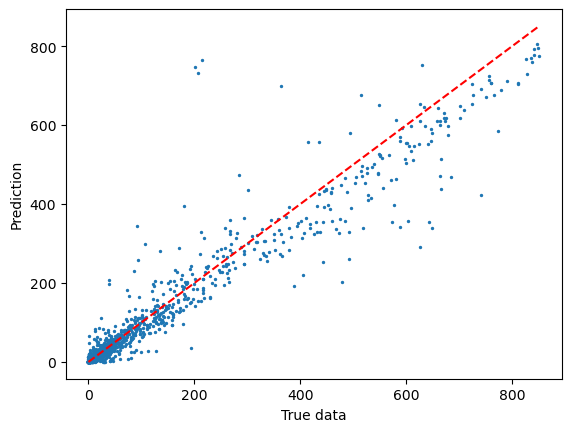

In [246]:
print("mae = ",mae)
X = np.linspace(0,max(Y_Test_est.max(), np.max(prediction)))
plt.scatter(Y_Test_est, prediction, s=2)
plt.plot(X,X, '--',c='r')
plt.xlabel("True data")
plt.ylabel("Prediction")
plt.show()

## LGB as first model

In [229]:
import lightgbm as lgb
lgb_model = lgb.LGBMRegressor(tree_learner= 'serial',
                              num_threads= 2,
                              num_leaves= 500,
                              n_estimators= 1000,
                              metric= 'mae',
                              reg_lambda = 0.0001,
                              learning_rate= 0.08)
lgb_model.fit(X_Train,Y_Train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15281
[LightGBM] [Info] Number of data points in the train set: 30430, number of used features: 96
[LightGBM] [Info] Start training from score 217.763297


LGBMRegressor(learning_rate=0.08, metric='mae', n_estimators=1000,
              num_leaves=500, num_threads=2, reg_lambda=0.0001,
              tree_learner='serial')

mae =  20.598362353512574


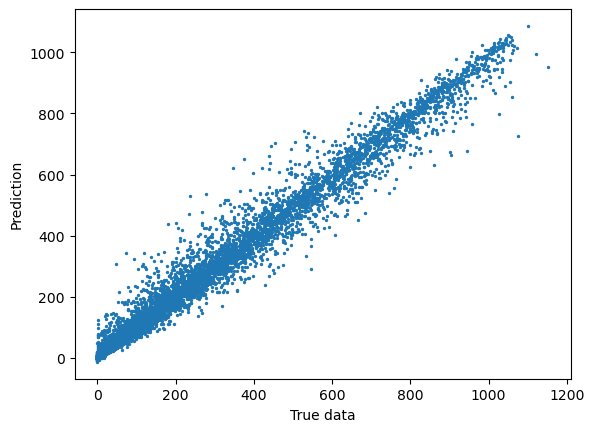

In [230]:
prediction_lgb = lgb_model.predict(X_Test)

mae = mean_absolute_error(Y_Test, prediction_lgb)
print("mae = ",mae)

plt.scatter(Y_Test, prediction_lgb, s=2)
plt.xlabel("True data")
plt.ylabel("Prediction")
plt.show()

In [231]:
#Split Train, Validation, Test estimated data
X_Train_est_,X_Test_est, Y_Train_est_, Y_Test_est = train_test_split(X_Train_est_init, Y_Train_est_init,
                                                    test_size=0.2,
                                                    shuffle=True
                                                    )
X_Train_est, X_Val_est, Y_Train_est, Y_Val_est = train_test_split(X_Train_est_, Y_Train_est_,
                                                    test_size=0.2,
                                                    shuffle=True
                                                    )

mae =  97.8412354496397


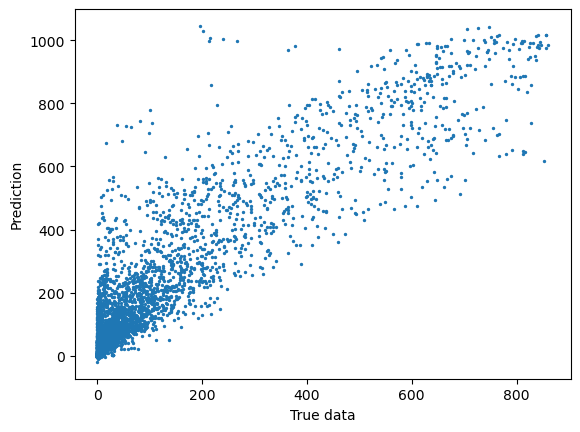

In [232]:
# Predict on test data
prediction_lgb_Train = lgb_model.predict(X_Train_est)
prediction_lgb_Val = lgb_model.predict(X_Val_est)
prediction_lgb_Test = lgb_model.predict(X_Test_est)

mae = mean_absolute_error(Y_Train_est, prediction_lgb_Train)
print("mae = ",mae)

plt.scatter(Y_Train_est, prediction_lgb_Train, s=2)
plt.xlabel("True data")
plt.ylabel("Prediction")
plt.show()

In [233]:
#Add this prediction as a feature for next network
scaler = StandardScaler()
prediction_normalized_Train = scaler.fit_transform(np.reshape(prediction_lgb_Train, (prediction_lgb_Train.shape[0],1)) )
prediction_normalized_Val = scaler.fit_transform(np.reshape(prediction_lgb_Val, (prediction_lgb_Val.shape[0],1 )))
prediction_normalized_Test = scaler.fit_transform(np.reshape(prediction_lgb_Test, (prediction_lgb_Test.shape[0],1)))

X_Train_est.insert(X_Train_est.shape[1],'prediction',prediction_normalized_Train)
X_Val_est.insert(X_Val_est.shape[1],'prediction',prediction_normalized_Val)
X_Test_est.insert(X_Test_est.shape[1],'prediction',prediction_normalized_Test)

In [234]:
input_shape = X_Train_est.shape[1]
epochs = 500
batch_size = 256

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  patience = 20, 
                                                  mode = "min", 
                                                  verbose=1,
                                                  restore_best_weights = False, 
                                                  start_from_epoch = 20)


model_NN = create_NN_model(input_shape)
model_NN.compile(optimizer='Adam', loss='mae')
history = model_NN.fit(x=X_Train_est,
                    y=Y_Train_est,
                    batch_size = batch_size, 
                    steps_per_epoch=1, 
                    epochs= epochs, 
                    verbose=2,
                    validation_data = [X_Val_est, Y_Val_est],
                    callbacks = [early_stopping] 
                    )
 
    # Evaluate the model on the test data
prediction =model_NN.predict(X_Test_est)
prediction[prediction<0] = 0
mae = mean_absolute_error(Y_Test_est, prediction)

Epoch 1/500
1/1 - 2s - loss: 110.1667 - val_loss: 134.5664 - 2s/epoch - 2s/step
Epoch 2/500
1/1 - 0s - loss: 121.9404 - val_loss: 133.9904 - 89ms/epoch - 89ms/step
Epoch 3/500
1/1 - 0s - loss: 121.6451 - val_loss: 133.2408 - 86ms/epoch - 86ms/step
Epoch 4/500
1/1 - 0s - loss: 124.6607 - val_loss: 132.2688 - 81ms/epoch - 81ms/step
Epoch 5/500
1/1 - 0s - loss: 139.5354 - val_loss: 131.0234 - 82ms/epoch - 82ms/step
Epoch 6/500
1/1 - 0s - loss: 126.5485 - val_loss: 129.4379 - 79ms/epoch - 79ms/step
Epoch 7/500
1/1 - 0s - loss: 116.0956 - val_loss: 127.4491 - 81ms/epoch - 81ms/step
Epoch 8/500
1/1 - 0s - loss: 119.5224 - val_loss: 125.1118 - 79ms/epoch - 79ms/step
Epoch 9/500
1/1 - 0s - loss: 100.1634 - val_loss: 122.4238 - 76ms/epoch - 76ms/step
Epoch 10/500
1/1 - 0s - loss: 102.0718 - val_loss: 119.7533 - 75ms/epoch - 75ms/step
Epoch 11/500
1/1 - 0s - loss: 116.9868 - val_loss: 117.3416 - 75ms/epoch - 75ms/step
Epoch 12/500
1/1 - 0s - loss: 129.8938 - val_loss: 114.8212 - 79ms/epoch - 79m

mae =  29.087633598506006


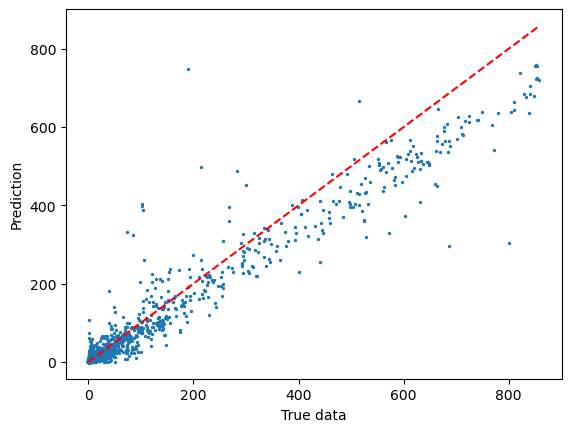

In [235]:
print("mae = ",mae)
X = np.linspace(0,max(Y_Test_est.max(), np.max(prediction)))
plt.scatter(Y_Test_est, prediction, s=2)
plt.plot(X,X, '--',c='r')
plt.xlabel("True data")
plt.ylabel("Prediction")
plt.show()